In [162]:
suppressWarnings(suppressPackageStartupMessages({
    library(Seurat)
    library(Signac)
    library(EnsDb.Hsapiens.v86)
    library(dplyr)
    library(ggplot2)
    library(bedr)
    library(SeuratDisk)
    library(scales)
    library(reshape2)
    library(Hmisc)
    library(tidyr)
    library(tidyverse)
    library(crayon)
    library(readr)
    library(future)
    library(combinat)
    library("TxDb.Hsapiens.UCSC.hg38.knownGene")
    library(GenomicRanges)
    library(GenomicFeatures)
    library(rsnps)
    library(biomaRt)
    library(ggpubr)
    library(gridExtra)
    library(patchwork)
    library(EnhancedVolcano)
    library(rlist)
    library(purrr)
}))
options(timeout=100000)
source('/home/vsevim/prj/workflows/ckd/secondary/helper_functions_for_diffex.r')

# Definitions etc

In [163]:
set.seed(1234)
options(digits=2)
stats <- c()

In [164]:
options(future.globals.maxSize= 250 * 1024^3) # 650Gb
# plan()

# Enable parallelization
plan(sequential)
plan("multicore", workers = 64)

In [165]:
if(!exists("papermill_run")) {
    prj_name = "Screen1_66guides"
    data_subdir_suffixes = "L1,L2,L3,L4"     
    secondary_a_path = "/home/vsevim/prj/1012-ckd/S1/analysis/secondary/"
    save_seurat_h5 = "YES"
}

In [166]:
custom_theme <- theme(
  plot.title = element_text(size=16, hjust = 0.5), 
  legend.key.size = unit(0.7, "cm"), 
  legend.text = element_text(size = 14))

Mark cells that are positive for given guides as guide_positive, all others as guide_negative

In [167]:
mark_guide_pos_neg <- function(seurat_obj, perturbed_cells_by_guide, guides, print_counts = T) {
    all_cells = Cells(seurat_obj)
    perturbed_cells = c()
    dummy_perturbed = c()
    
    for(guide in guides) {
        dummy_perturbed = unlist(perturbed_cells_by_guide[[guide]])
        perturbed_cells = union(perturbed_cells, dummy_perturbed)
        #cat(guide," ", length(perturbed_cells), "\n")
    }

    unperturbed_cells = unlist(setdiff(all_cells, perturbed_cells))
    Idents(seurat_obj) <- "guide_negative"
    seurat_obj <- SetIdent(seurat_obj, cells = perturbed_cells, value = "guide_positive") 

    if(print_counts) {
        n_gplus   = length(perturbed_cells)
        n_gminus = length(unperturbed_cells)    
        cat(blue("Guide+ =",n_gplus, "; Guide- =", n_gminus, "\n"))
    }
    
    seurat_obj
}

### Load guide df

In [168]:
df_guide = read.table("/home/vsevim/prj/1012-ckd/S2/scripts/library_csv/101_CRISPRa_ref_for_diffex.txt", sep = "\t", header = T, strip.white = T)
df_guide = read.table("/home/vsevim/prj/1012-ckd/S1/scripts/library_csv/66CRISPRi_ref_for_diffex.txt", sep = "\t", header = T, strip.white = T)
sample_n(df_guide, 6)

gene,guide1,guide2,alias,subclass,class,gene_or_rsid,label
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
rs7707989,DE4-2a,DE4-2b,DE4,ckd_de,targeting,rs7707989,CKD DE
rs2823139,DE1-2a,DE1-2b,DE1,ckd_de,targeting,rs2823139,CKD DE
rs881858,DE9-1a,DE9-1b,DE9,ckd_de,targeting,rs881858,CKD DE
rs6839100,DE12-2a,DE12-2b,DE12,ckd_de,targeting,rs6839100,CKD DE
rs4720089,DE14-1a,DE14-1b,DE14,ckd_de,targeting,rs4720089,CKD DE
Enh37-10-PLIN3,PLIN3-1a,PLIN3-1b,PLIN3,de_control,targeting,PLIN3,Control DE


### Load Seurat file

In [169]:
integrated_h5_path <- "/home/vsevim/prj/1012-ckd/S1/analysis/secondary/integrated/seurat_objects/integrated.h5seurat"
seurat_combined    <- LoadH5Seurat(integrated_h5_path, verbose = F)
#seurat_combined    <- subset(seurat_combined, subset=status=='singlet')

Validating h5Seurat file



Normalize RNA counts by <font color='red'>NormalizeData</font>  before running FindMarkers

In [ ]:
seurat_rna = CreateSeuratObject(seurat_combined[['RNA']])
seurat_rna <- NormalizeData(seurat_rna)
seurat_rna@meta.data <- seurat_combined@meta.data

### Load THRESHOLDS.tsv

In [ ]:
thr_f_name = paste0(secondary_a_path, "/integrated/THRESHOLDS.tsv")
df_thresholds = read.table(thr_f_name, header=T, strip.white = T)
df_thresholds <- df_thresholds %>% pivot_wider(names_from = batch, values_from = threshold)
df_thresholds <- as.data.frame(df_thresholds)

## Select perturbed/control cells
Find guide+ (perturbed) and guide- (unperturbed) cells for each guide

In [ ]:
libraries = unique(seurat_combined$library)
seurat_libs = list()
for(i in seq_along(libraries)){ 
    lib = libraries[i]
    seurat_libs[[i]] = subset(seurat_combined, subset = library == lib)
}
names(seurat_libs) <- libraries

In [ ]:
cat(red("Using 3x threshold"))
THRESHOLD_MULTIPLIER = 3

perturbed_cells_by_guide = list()

for(i in 1:nrow(df_thresholds)){  
    perturbed_cells_in_all_libs = list()
    guide = df_thresholds$guide[i]
    # Loop over libraries
    for(lib in libraries){        
        seurat_lib = seurat_libs[[lib]]
        threshold = THRESHOLD_MULTIPLIER * df_thresholds[i, lib]        
        #cat(blue(guide, lib, threshold, "\n"))
        cells_in_lib = Cells(seurat_lib)        
        sgrna_counts = seurat_lib[['sgRNA']]@counts
        select_perturbed = sgrna_counts[guide, cells_in_lib] >= threshold
        perturbed_cells_in_library = cells_in_lib[select_perturbed]
        #cat(length(cells_in_lib), "in", lib, guide, length(perturbed_cells_in_library), "cells >", threshold, "\n")        
        if(!is.na(threshold)) {
            perturbed_cells_in_all_libs = append(perturbed_cells_in_all_libs, perturbed_cells_in_library)
        }
    }
    perturbed_cells_by_guide[[i]] = perturbed_cells_in_all_libs
}
names(perturbed_cells_by_guide) <- df_thresholds$guide

Using 3x threshold

In [ ]:
length(perturbed_cells_by_guide[[3]])

[1] 753

In [ ]:
df_thresholds$guide[grepl("NT" , df_thresholds$guide)]

[1] "NTCE1-1a" "NTCE1-1b" "NTCE2-1a" "NTCE2-1b" "NTCE3-1a" "NTCE3-1b" "NTCE4-1a"
[8] "NTCE4-1b"

# Check DE for genes near SNPs

In [ ]:
select_distal  = df_guide$subclass == 'ckd_de'
df_snps = unique(df_guide[select_distal, c('gene','alias')])

* * * * *
I skip DE 20 because it doesn't have a rsID. Use it's coords instead 
* * * * *

In [ ]:
snp_coords = ncbi_snp_query(df_snps$gene)

Getting info about the following rsIDs: rs2823139, rs7642977, rs78581838, rs7707989, rs527616, rs10283362, rs34861762, rs16874072, rs881858, rs4669722, rs76839935, rs6839100, rs11154336, rs4720089, rs2979488, rs2661503, rs10224210



In [ ]:
#snp_upstream_range   = 1000000
#snp_downstream_range = 1000000

df_snp_coords                 = data.frame(chr=paste0("chr", snp_coords$chromosome))
df_snp_coords$start_position  = snp_coords$bp #+ snp_upstream_range
df_snp_coords$end_position    = snp_coords$bp #+ snp_downstream_range
df_snp_coords$strand          = '*'
df_snp_coords$hgnc_symbol     = snp_coords$rsid
df_snp_coords$chromosome_name = snp_coords$chromosome
#snp_granges = makeGRangesFromDataFrame(df_dummy)

Include distal elements with no rs number

In [ ]:
select_distal  = df_guide$subclass == 'ckd_de_no_rs'
df_nors_snps = unique(df_guide[select_distal, c('gene','alias')])
chr_and_coords = str_split(df_nors_snps$gene, "_")
df_dummy = data.frame(t(Reduce(rbind, chr_and_coords)))
colnames(df_dummy) <- c("chr", "start")

df_nors_snps$chr = paste0('chr', df_dummy$chr)
df_nors_snps$start_position  = as.numeric(df_dummy$start)
df_nors_snps$end_position    = as.numeric(df_dummy$start)
df_nors_snps$strand          = "*"
df_nors_snps$hgnc_symbol     = df_nors_snps$gene
df_nors_snps$chromosome_name = df_dummy$chr

ERROR: Error in t.default(Reduce(rbind, chr_and_coords)): argument is not a matrix


In [ ]:
select_cols = c('chr', 'start_position', 'end_position','strand', 'hgnc_symbol', 'chromosome_name')
df_nors_snps = df_nors_snps[, select_cols]
df_snp_coords = rbind(df_snp_coords, df_nors_snps)

In [ ]:
head(df_snp_coords)

,chr,start_position,end_position,strand,hgnc_symbol,chromosome_name
,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>
1,chr21,1.5e+07,1.5e+07,*,rs2823139,21
2,chr3,1.9e+08,1.9e+08,*,rs7642977,3
3,chr21,1.5e+07,1.5e+07,*,rs78581838,21
4,chr5,6.8e+07,6.8e+07,*,rs7707989,5
5,chr18,2.7e+07,2.7e+07,*,rs527616,18
6,chr8,1.3e+08,1.3e+08,*,rs10283362,8


Load annotations

In [ ]:
#searchDatasets(mart = ensembl, pattern = "hsapiens")
#mart <- useMart("ensembl")
#mart <- useDataset("hsapiens_gene_ensembl", mart)

# Find neighbors of targets

In [ ]:
genes_in_assay = rownames(seurat_rna[['RNA']]@counts)
options(timeout=100000)
mart <- useEnsembl(biomart = "genes", dataset = "hsapiens_gene_ensembl", mirror="useast")
#m <- useMart('ensembl', dataset='hsapiens_gene_ensembl') # create a mart object

In [ ]:
source('/home/vsevim/prj/workflows/ckd/secondary/helper_functions_for_diffex.r')
control_targets = unique(filter(df_guide, subclass=='tss' | subclass == 'de_control')[,c('alias')])

df_target_coords <- getBM(mart=mart, attributes=c('hgnc_symbol', 'description', 'chromosome_name',
                                 'start_position', 'end_position', 'strand',
                                 'ensembl_gene_id'),
                        filters = 'hgnc_symbol', values = control_targets)
                        
df_target_coords <- filter(df_target_coords, chromosome_name %in% c(1:23, "X","Y"))

In [ ]:
gene_neighbors_list = get_neighboring_genes(bm, df_target_coords, genes_in_assay)
snp_neighbors_list  = get_neighboring_genes(bm, df_snp_coords, genes_in_assay)
neighbors_list =  append(gene_neighbors_list, snp_neighbors_list) 

ANPEP 15 88784895 90815401 
C15orf40 15 81988441 84011641 
CD55 1 206321519 208386804 
CSTB 21 42772511 44776330 
CTSB 8 10842524 12869533 
FTH1 11 60959718 62967634 
FUBP1 1 76944055 78979110 
KLF6 10 2775996 4785281 
LGALS3 14 54124110 56145423 
MAFF 22 37200767 39216507 
NT5E 6 84449584 86495791 
PLIN3 19 3838341 5867694 
TKT 3 52224712 54256052 
rs2823139 21 14204463 16204463 
rs7642977 3 193092961 195092961 
rs78581838 21 13864259 15864259 
rs7707989 5 67396052 69396052 
rs527616 18 25757460 27757460 
rs10283362 8 132320717 134320717 
rs34861762 8 22890907 24890907 
rs16874072 4 22741827 24741827 
rs881858 6 42838872 44838872 
rs4669722 2 10390110 12390110 
rs76839935 7 150870466 152870466 
rs6839100 4 75458036 77458036 
rs11154336 6 124899862 126899862 
rs4720089 7 31964026 33964026 
rs2979488 8 29423114 31423114 
rs2661503 6 50644819 52644819 
rs10224210 7 150716108 152716108 


In [ ]:
list.save(neighbors_list, "/home/vsevim/prj/1012-ckd/S1/scripts/library_csv/neighbors_list.rds")

## Run diffex on genes neighboring the snps w/ min_LFC = 0.10

In [ ]:
df_targets = unique(filter(df_guide, subclass=='ckd_de')[,c('alias','gene','subclass', 'label')])
df_targets = unique(filter(df_guide, class=='targeting')[,c('alias','gene','subclass', 'label')])
df_neighbor_de = NULL
test_use =  "LR" #"MAST"  "wilcox" "LR"
guides_to_skip = c()
#c("LGALS3", "CTSB", "CSTB", "DE3", "DE4", "DE11", "DE12", "DE18", "DE19", "DE20", "DE21", "DE22", "DE23", "ICAM2", "FGFR3", "IQGAP2")  
logfc_threshold = 0.10
n_tests = 0

for(i in nrow(df_targets):1) {
    target          = df_targets[i,'alias']
    target_subclass = df_targets[i, 'subclass']
    label           = df_targets[i, 'label']
    snp_id_or_gene_name = df_targets[i,'gene']

    if(!str_detect(target, regex("^DE\\d+$"))) {
        ckd_de = 
        neigbors = neighbors_list[[target]]
    } else {
        neigbors = neighbors_list[[snp_id_or_gene_name]]
    }
    
    if((target %in% guides_to_skip) | length(neigbors) == 0 ){
        cat(red("Skipping", target, snp_id_or_gene_name, length(neigbors), "\n"))
        next
    }
    guides_4_target = get_guides_by_subclass(df_guide, 'alias', target)
    cat(blue(target, target,":"), paste(guides_4_target, collapse=","),"\n")
    seurat_dummy <- mark_guide_pos_neg(seurat_rna, perturbed_cells_by_guide, guides_4_target, print_counts = T)
    n_tests = n_tests + length(neigbors)

    markers <- FindMarkers(
        object = seurat_dummy,
        features = neigbors,
        slot = "data",
        ident.1 = 'guide_positive',
        ident.2 = 'guide_negative',
        test.use = test_use,
        logfc.threshold = logfc_threshold,
        latent.vars = c("library", "donor"),
        only.pos = FALSE, 
        verbose = FALSE
    )
    # 
    # latent.vars = c('library') 
    if(nrow(markers)==0) {
        cat(red("No DE genes", test_use,":", target, "\n"))
        next
    } 
    markers$de_gene = rownames(markers)
    markers$target = target
    markers$subclass = target_subclass
    markers$label = label
    rownames(markers) <- NULL
    df_neighbor_de = rbind(df_neighbor_de, markers)
    print(markers)
}

DE17 DE17 : DE17-1a,DE17-2a,DE17-1b,DE17-2b 
Guide+ = 1922 ; Guide- = 25220 


Warning message in FindMarkers.default(object = data.use, slot = data.slot, counts = counts, :
"No features pass logfc.threshold threshold; returning empty data.frame"


No DE genes LR : DE17 
DE16 DE16 : DE16-1a,DE16-2a,DE16-1b,DE16-2b 
Guide+ = 1760 ; Guide- = 25382 
    p_val avg_log2FC pct.1 pct.2 p_val_adj de_gene target subclass  label
1 2.5e-05      -0.12  0.59  0.61      0.91   PKHD1   DE16   ckd_de CKD DE
DE15 DE15 : DE15-1a,DE15-2a,DE15-1b,DE15-2b 
Guide+ = 2198 ; Guide- = 24944 
    p_val avg_log2FC pct.1 pct.2 p_val_adj de_gene target subclass  label
1 3.6e-74      -0.33  0.95  0.97   1.3e-69   RBPMS   DE15   ckd_de CKD DE
DE14 DE14 : DE14-1a,DE14-2a,DE14-1b,DE14-2b 
Guide+ = 2108 ; Guide- = 25034 


Warning message in FindMarkers.default(object = data.use, slot = data.slot, counts = counts, :
"No features pass logfc.threshold threshold; returning empty data.frame"


No DE genes LR : DE14 
DE13 DE13 : DE13-1a,DE13-2a,DE13-1b,DE13-2b 
Guide+ = 1530 ; Guide- = 25612 


Warning message in FindMarkers.default(object = data.use, slot = data.slot, counts = counts, :
"No features pass logfc.threshold threshold; returning empty data.frame"


No DE genes LR : DE13 
DE12 DE12 : DE12-1a,DE12-2a,DE12-1b,DE12-2b 
Guide+ = 1982 ; Guide- = 25160 


Warning message in FindMarkers.default(object = data.use, slot = data.slot, counts = counts, :
"No features pass logfc.threshold threshold; returning empty data.frame"


No DE genes LR : DE12 
DE11 DE11 : DE11-1a,DE11-2a,DE11-1b,DE11-2b 
Guide+ = 2076 ; Guide- = 25066 


Warning message in FindMarkers.default(object = data.use, slot = data.slot, counts = counts, :
"No features pass logfc.threshold threshold; returning empty data.frame"


No DE genes LR : DE11 
DE10 DE10 : DE10-1a,DE10-2a,DE10-1b,DE10-2b 
Guide+ = 1822 ; Guide- = 25320 
    p_val avg_log2FC pct.1 pct.2 p_val_adj de_gene target subclass  label
1 5.1e-12      -0.11  0.97  0.97   1.9e-07   PDIA6   DE10   ckd_de CKD DE
DE9 DE9 : DE9-1a,DE9-2a,DE9-1b,DE9-2b 
Guide+ = 1206 ; Guide- = 25936 


Warning message in FindMarkers.default(object = data.use, slot = data.slot, counts = counts, :
"No features pass logfc.threshold threshold; returning empty data.frame"


No DE genes LR : DE9 
DE8 DE8 : DE8-1a,DE8-2a,DE8-1b,DE8-2b 
Guide+ = 2487 ; Guide- = 24655 


Warning message in FindMarkers.default(object = data.use, slot = data.slot, counts = counts, :
"No features pass logfc.threshold threshold; returning empty data.frame"


No DE genes LR : DE8 
DE7 DE7 : DE7-1a,DE7-2a,DE7-1b,DE7-2b 
Guide+ = 2144 ; Guide- = 24998 
    p_val avg_log2FC pct.1 pct.2 p_val_adj   de_gene target subclass  label
1 6.0e-16      -0.11  0.32  0.40   2.2e-11      STC1    DE7   ckd_de CKD DE
2 1.3e-15       0.12  0.83  0.77   4.6e-11 TNFRSF10B    DE7   ckd_de CKD DE
3 6.3e-11      -0.10  0.51  0.55   2.3e-06     LOXL2    DE7   ckd_de CKD DE
DE6 DE6 : DE6-1a,DE6-2a,DE6-1b,DE6-2b 
Guide+ = 2655 ; Guide- = 24487 
     p_val avg_log2FC pct.1 pct.2 p_val_adj de_gene target subclass  label
1 4.1e-127      -0.36  0.51  0.68  1.5e-122   NDRG1    DE6   ckd_de CKD DE
DE5 DE5 : DE5-1a,DE5-2a,DE5-1b,DE5-2b 
Guide+ = 2335 ; Guide- = 24807 


Warning message in FindMarkers.default(object = data.use, slot = data.slot, counts = counts, :
"No features pass logfc.threshold threshold; returning empty data.frame"


No DE genes LR : DE5 
DE4 DE4 : DE4-1a,DE4-2a,DE4-1b,DE4-2b 
Guide+ = 2354 ; Guide- = 24788 
  p_val avg_log2FC pct.1 pct.2 p_val_adj de_gene target subclass  label
1 2e-12      -0.15  0.23  0.26   7.2e-08   CCNB1    DE4   ckd_de CKD DE
DE3 DE3 : DE3-1a,DE3-2a,DE3-1b,DE3-2b 
Guide+ = 2241 ; Guide- = 24901 


Warning message in FindMarkers.default(object = data.use, slot = data.slot, counts = counts, :
"No features pass logfc.threshold threshold; returning empty data.frame"


No DE genes LR : DE3 
DE2 DE2 : DE2-1a,DE2-2a,DE2-1b,DE2-2b 
Guide+ = 1162 ; Guide- = 25980 


Warning message in FindMarkers.default(object = data.use, slot = data.slot, counts = counts, :
"No features pass logfc.threshold threshold; returning empty data.frame"


No DE genes LR : DE2 
DE1 DE1 : DE1-1a,DE1-2a,DE1-1b,DE1-2b 
Guide+ = 2118 ; Guide- = 25024 
    p_val avg_log2FC pct.1 pct.2 p_val_adj de_gene target subclass  label
1 1.8e-10       0.11  0.94  0.91   6.4e-06   NRIP1    DE1   ckd_de CKD DE
KLF6 KLF6 : KLF6-1a,KLF6-2a,KLF6-1b,KLF6-2b 
Guide+ = 2080 ; Guide- = 25062 
  p_val avg_log2FC pct.1 pct.2 p_val_adj de_gene target   subclass      label
1 6e-48      -0.26  0.86   0.9   2.2e-43    KLF6   KLF6 de_control Control DE
CTSB CTSB : CTSB-1a,CTSB-2a,CTSB-1b,CTSB-2b 
Guide+ = 2079 ; Guide- = 25063 
     p_val avg_log2FC pct.1 pct.2 p_val_adj de_gene target   subclass
1 2.4e-142      -0.72  0.94  0.96  8.9e-138    CTSB   CTSB de_control
2  1.3e-09      -0.10  0.71  0.72   4.8e-05   FDFT1   CTSB de_control
       label
1 Control DE
2 Control DE
CSTB CSTB : CSTB-1a,CSTB-2a,CSTB-1b,CSTB-2b 
Guide+ = 2208 ; Guide- = 24934 
     p_val avg_log2FC pct.1 pct.2 p_val_adj de_gene target   subclass
1 2.7e-110      -0.31  0.95  0.98  9.7e-106    CSTB  

In [ ]:
#rownames(df_neighbor_de) <- df_neighbor_de$de_gene
head(df_neighbor_de[df_neighbor_de$target == "CSTB",], 20)

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,de_gene,target,subclass,label
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
13,2.7e-110,-0.31,0.95,0.98,9.7e-106,CSTB,CSTB,de_control,Control DE


### Correct p-values by total number of comparisons

In [ ]:
#n_tests = length(flatten(neighbors_list)) * 
print(n_tests)
df_neighbor_de$p_val_adj_mine =  p.adjust(
    p = df_neighbor_de$p_val,
    method = "bonferroni",
    n = n_tests
)


[1] 725


In [ ]:
select_significant_p  = df_neighbor_de$p_val_adj_mine < 1
df_neighbor_de        = df_neighbor_de[select_significant_p,]
head(df_neighbor_de[df_neighbor_de$target == "CSTB",], 20)

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,de_gene,target,subclass,label,p_val_adj_mine
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>
13,2.7e-110,-0.31,0.95,0.98,9.7e-106,CSTB,CSTB,de_control,Control DE,1.9e-107


In [ ]:
head(df_neighbor_de, 20)

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,de_gene,target,subclass,label,p_val_adj_mine
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>
1,2.5e-05,-0.12,0.59,0.61,9.1e-01,PKHD1,DE16,ckd_de,CKD DE,1.8e-02
2,3.6e-74,-0.33,0.95,0.97,1.3e-69,RBPMS,DE15,ckd_de,CKD DE,2.6e-71
3,5.1e-12,-0.11,0.97,0.97,1.9e-07,PDIA6,DE10,ckd_de,CKD DE,3.7e-09
4,6.0e-16,-0.11,0.32,0.40,2.2e-11,STC1,DE7,ckd_de,CKD DE,4.4e-13
5,1.3e-15,0.12,0.83,0.77,4.6e-11,TNFRSF10B,DE7,ckd_de,CKD DE,9.2e-13
6,6.3e-11,-0.10,0.51,0.55,2.3e-06,LOXL2,DE7,ckd_de,CKD DE,4.6e-08
7,4.1e-127,-0.36,0.51,0.68,1.5e-122,NDRG1,DE6,ckd_de,CKD DE,3.0e-124
8,2.0e-12,-0.15,0.23,0.26,7.2e-08,CCNB1,DE4,ckd_de,CKD DE,1.4e-09
9,1.8e-10,0.11,0.94,0.91,6.4e-06,NRIP1,DE1,ckd_de,CKD DE,1.3e-07


## Run diffex on genes neighboring the snps, and determine a p-value cutoff

In [ ]:
# df_targets = unique(filter(df_guide, subclass=='ckd_de')[,c('alias','gene','subclass', 'label')])
# df_targets = unique(filter(df_guide, class=='targeting')[,c('alias','gene','subclass', 'label')])
# df_neighbor_de = NULL
# test_use = "LR" #"MAST"  #"wilcox" "LR"
# guides_to_skip = c()  #c("DE6", "DE15")  
# logfc_threshold = 0.01

# for(i in 1:nrow(df_targets)) {
#     target          = df_targets[i,'alias']
#     target_subclass = df_targets[i, 'subclass']
#     label           = df_targets[i, 'label']
#     snp_id_or_gene_name = df_targets[i,'gene']
    
#     if(!str_detect(target, regex("^DE\\d+$"))) {
#         ckd_de = 
#         neigbors = neighbors_list[[target]]
#     } else {
#         neigbors = neighbors_list[[snp_id_or_gene_name]]
#     }

#     if((target %in% guides_to_skip) | length(neigbors) == 0 ){
#         cat(red("Skipping", target, snp_id_or_gene_name, length(neigbors), "\n"))
#         next
#     }
#     guides_4_target = get_guides_by_subclass(df_guide, 'alias', target)
#     cat(blue(target, target,":"), paste(guides_4_target, collapse=","),"\n")
#     seurat_dummy <- mark_guide_pos_neg(seurat_rna, perturbed_cells_by_guide, guides_4_target, print_counts = T)
#     seurat_dummy$my_ident = Idents(seurat_dummy)
#     n_guide_positive = sum(seurat_dummy$my_ident == 'guide_positive')

#     # markers <- FindMarkers(
#     #     object = seurat_dummy,
#     #     features = neigbors,
#     #     slot = "data",
#     #     ident.1 = 'guide_positive',
#     #     ident.2 = 'guide_negative',
#     #     test.use = test_use,
#     #     logfc.threshold = logfc_threshold,
#     #     latent.vars = c("library", "donor"),
#     #     only.pos = FALSE, 
#     #     verbose = FALSE
#     # )
#     # 
#     # latent.vars = c('library') 
#     if(nrow(markers)==0) {
#         cat(red("No DE genes", test_use,":", target, "\n"))
#         next
#     } 
#     markers$de_gene = rownames(markers)
#     markers$target = target
#     markers$subclass = target_subclass
#     markers$label = label
#     rownames(markers) <- NULL
#     df_neighbor_de = rbind(df_neighbor_de, markers)
#     #print(markers)

#     #### Determine p-value cutoff ####
#     seurat_dummy = subset(seurat_dummy, ident='guide_negative')
#     DefaultAssay(seurat_dummy) <- "RNA"
#     random_g_positive_set = sample(Cells(seurat_dummy), n_guide_positive, replace = F)
#     seurat_dummy@meta.data[random_g_positive_set, 'my_ident'] = "guide_positive"
#     Idents(seurat_dummy) = seurat_dummy$my_ident
#     #print(table(Idents(seurat_dummy)))

#     markers <- FindMarkers(
#         object = seurat_dummy,
#         features = neigbors,
#         slot = "data",
#         ident.1 = 'guide_positive',
#         ident.2 = 'guide_negative',
#         test.use = test_use,
#         logfc.threshold = logfc_threshold,
#         latent.vars = c("library", "donor"),
#         only.pos = FALSE, 
#         verbose = FALSE
#     )
#     cat(green(target, "p-val cutoff= ", min(markers$p_val)), "\n")
    
# }

In [ ]:
markers$p_val*34

[1] 6.3e-150  3.1e-12

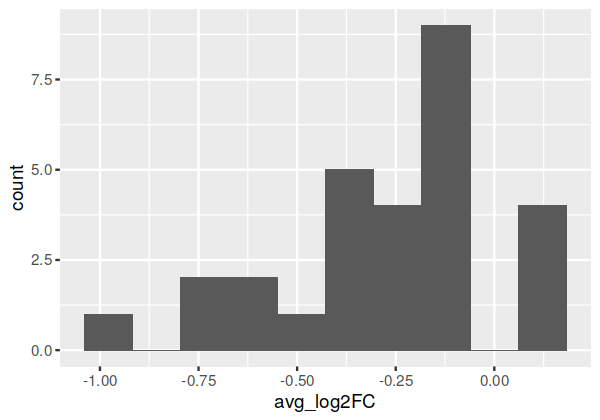

In [ ]:
options(repr.plot.width=5, repr.plot.height=3.5)
ggplot(df_neighbor_de, aes(x = avg_log2FC)) +
    geom_histogram(bins=10)

In [ ]:
nrow(df_neighbor_de)
head(df_neighbor_de)

[1] 28

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,de_gene,target,subclass,label,p_val_adj_mine
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>
1,2.5e-05,-0.12,0.59,0.61,9.1e-01,PKHD1,DE16,ckd_de,CKD DE,1.8e-02
2,3.6e-74,-0.33,0.95,0.97,1.3e-69,RBPMS,DE15,ckd_de,CKD DE,2.6e-71
3,5.1e-12,-0.11,0.97,0.97,1.9e-07,PDIA6,DE10,ckd_de,CKD DE,3.7e-09
4,6.0e-16,-0.11,0.32,0.40,2.2e-11,STC1,DE7,ckd_de,CKD DE,4.4e-13
5,1.3e-15,0.12,0.83,0.77,4.6e-11,TNFRSF10B,DE7,ckd_de,CKD DE,9.2e-13
6,6.3e-11,-0.10,0.51,0.55,2.3e-06,LOXL2,DE7,ckd_de,CKD DE,4.6e-08


## Volcano Plot

In [ ]:
colors <- ifelse(
    df_neighbor_de$subclass == 'tss', 'black',
    ifelse(df_neighbor_de$subclass == 'de_control', 'gray', 'green') 
)
names(colors) <- df_neighbor_de$label

Warning message:
"One or more p-values is 0. Converting to 10^-1 * current lowest non-zero p-value..."


Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Warning message:
"ggrepel: 3 unlabeled data points (too many overlaps). Consider increasing max.overlaps"


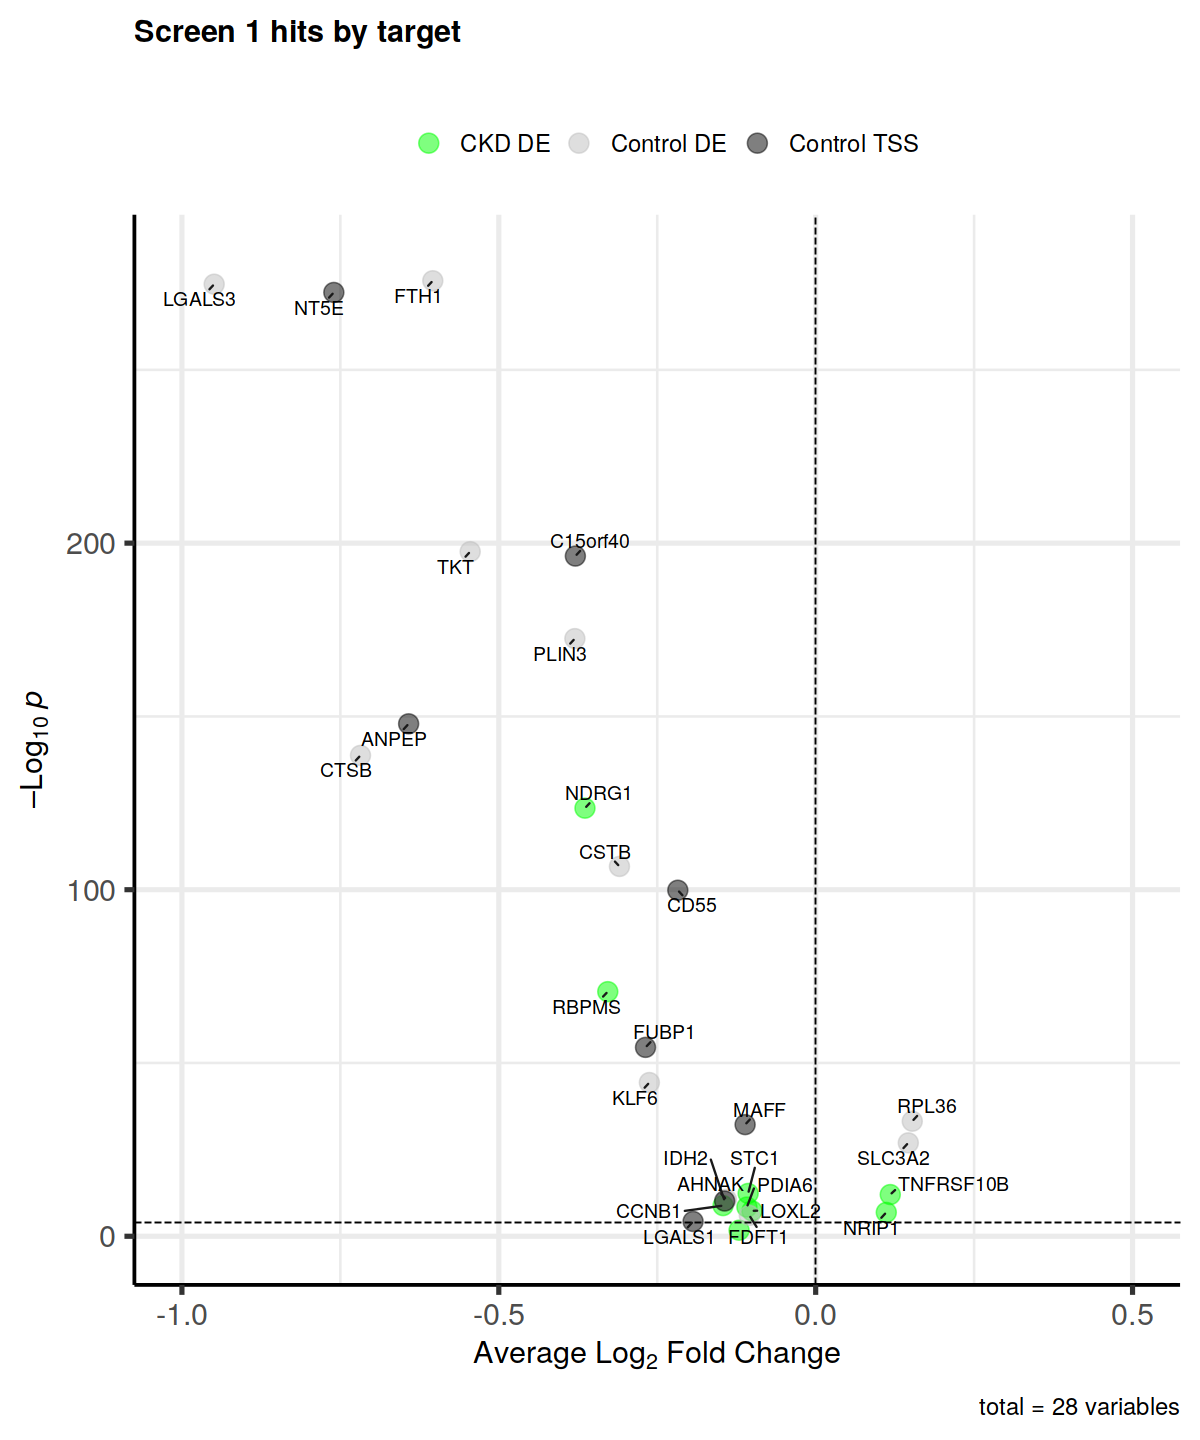

In [ ]:
options(repr.plot.width = 10, repr.plot.height = 12)
EnhancedVolcano(df_neighbor_de, 
                lab = df_neighbor_de$de_gene,
                x ="avg_log2FC",
                y ="p_val_adj_mine",
                title = 'Screen 1 hits by target',
                subtitle = '', 
                colCustom = colors,
                drawConnectors = TRUE,
                arrowheads = FALSE,
                pCutoff = 10e-5,
                FCcutoff = 0.,
                pointSize = 5.0,
                labSize = 4.0
                ) +
                xlim(-1, .5) +
                xlab(expression(paste("Average ", Log[2], " Fold Change"))) +
                ylab(expression(paste("\u2013", Log[10], " ", italic(p))))

# lab = df_neighbor_de$de_gene,
# drawConnectors = TRUE,

### Plot just the control TSS

Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.


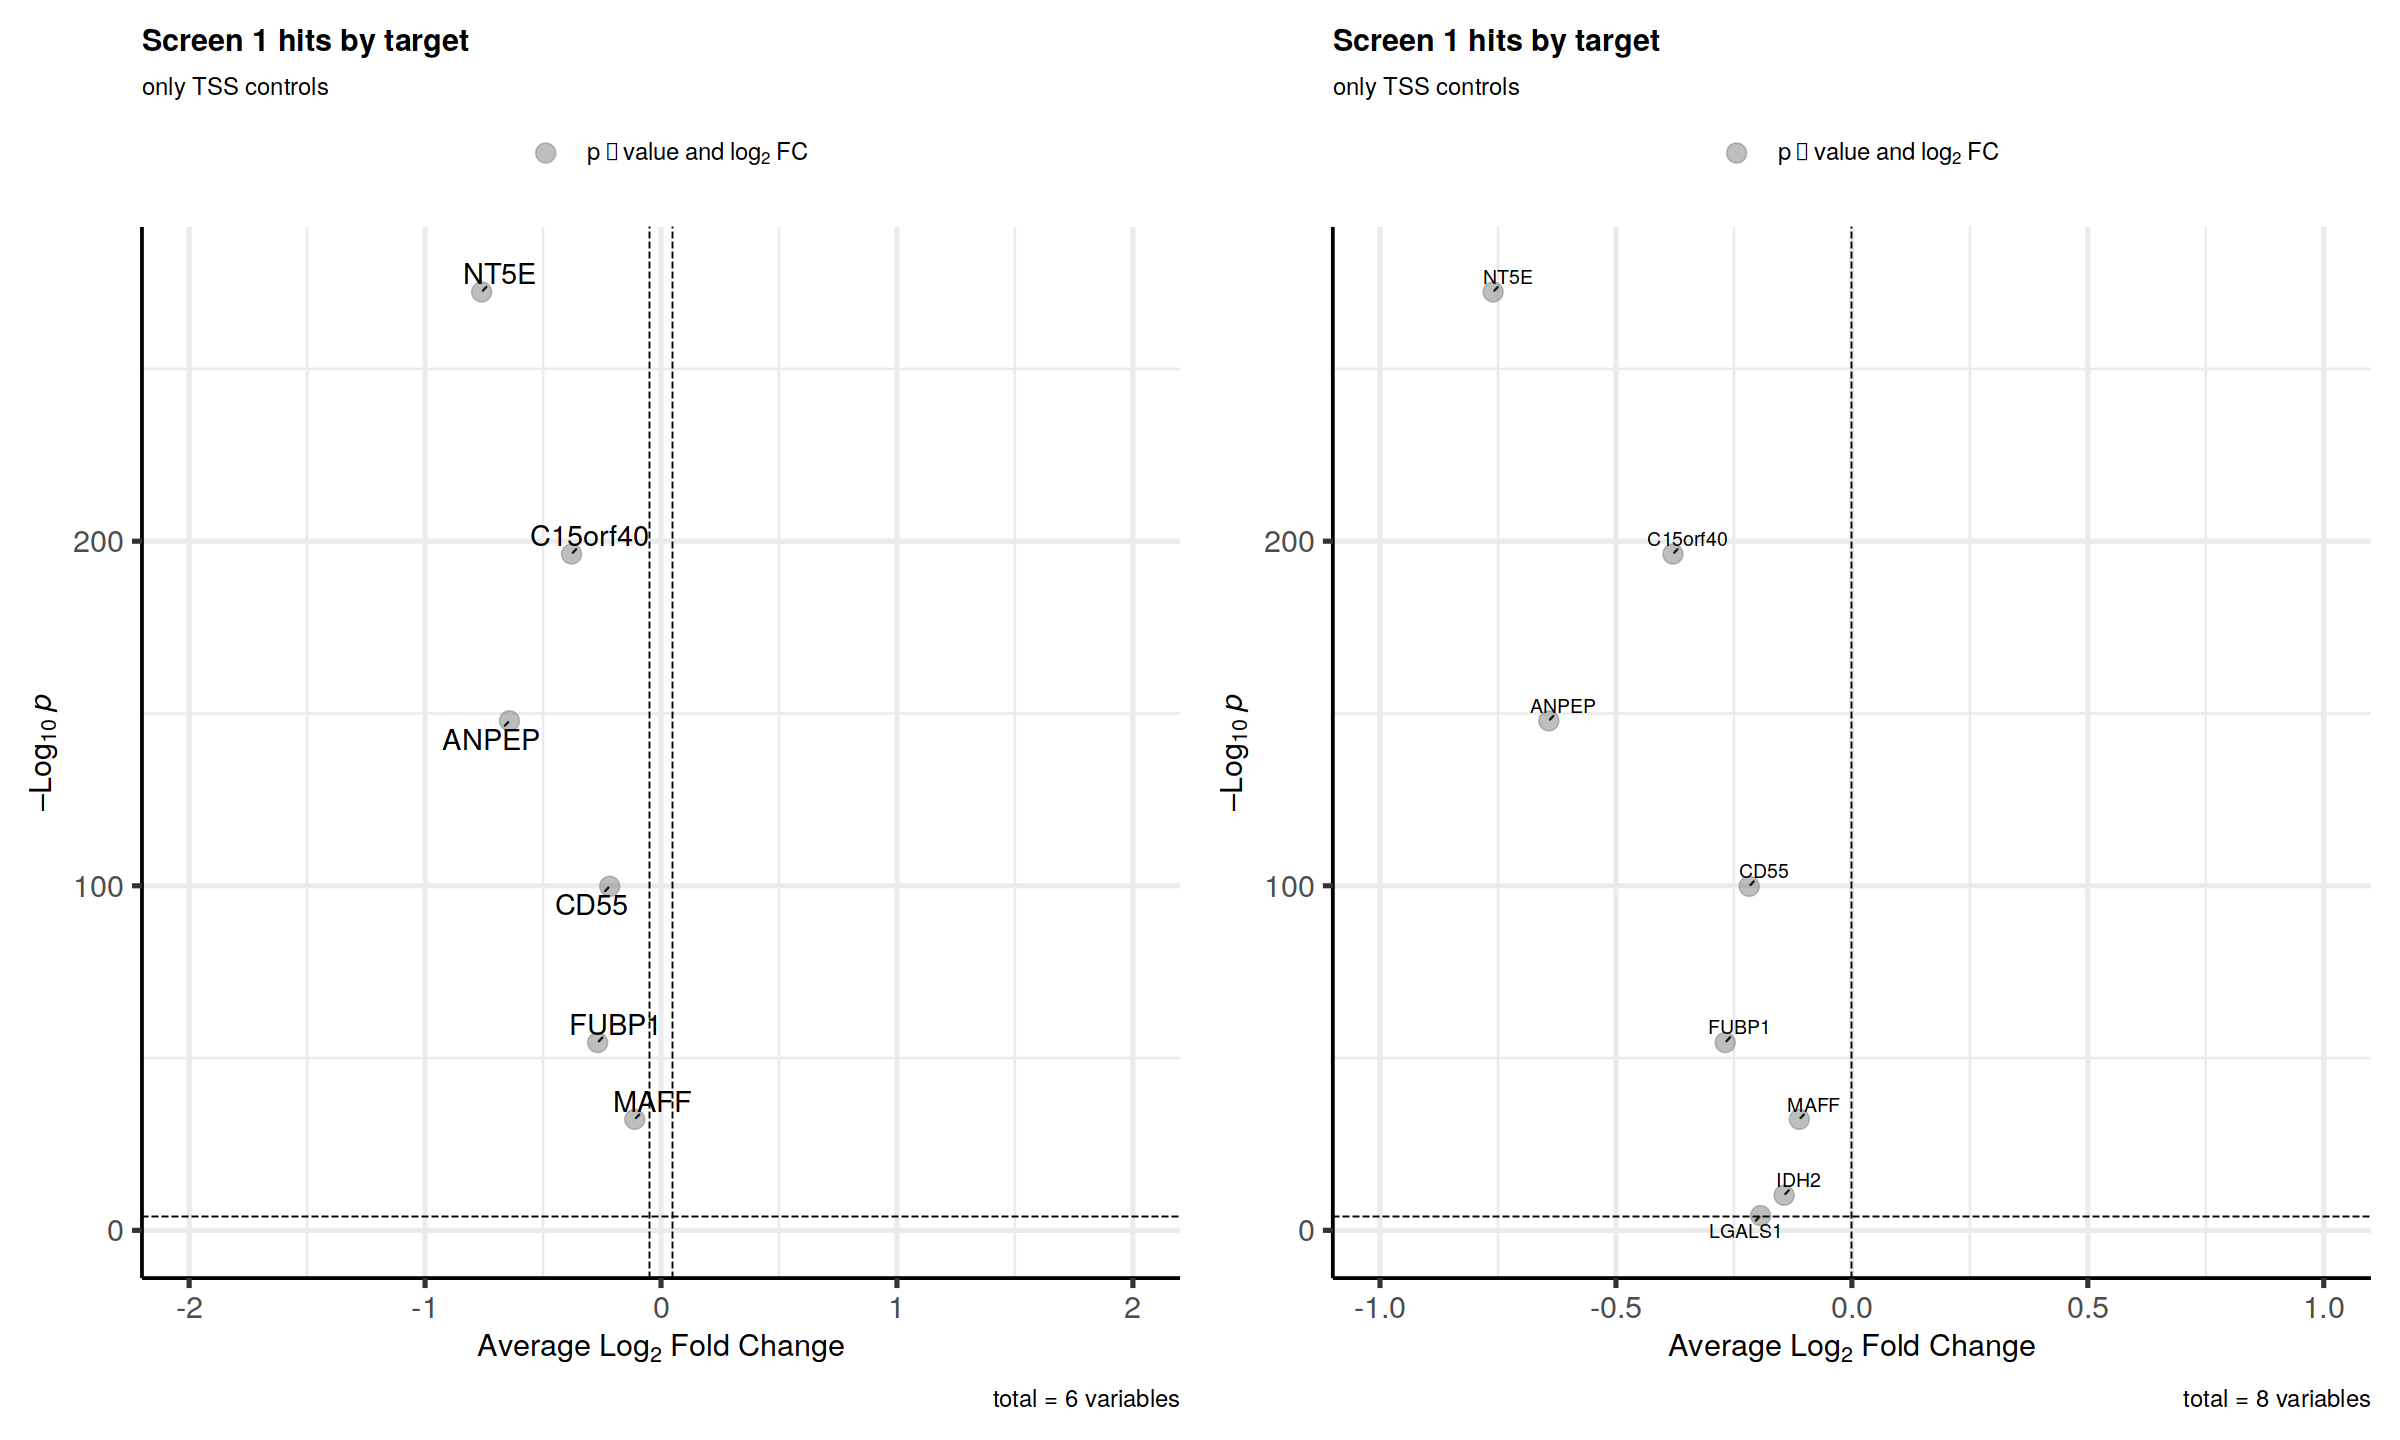

In [ ]:
de_filter = (df_neighbor_de$subclass == 'tss') & (df_neighbor_de$target == df_neighbor_de$de_gene)
df_neighbor_de_subset = df_neighbor_de[de_filter ,]

options(repr.plot.width = 20, repr.plot.height = 12)
p1 = EnhancedVolcano(df_neighbor_de_subset, 
                lab = df_neighbor_de_subset$de_gene,
                x ="avg_log2FC",
                y ="p_val_adj_mine",
                title = 'Screen 1 hits by target',
                subtitle = 'only TSS controls', 
                col = 'gray',
                drawConnectors = TRUE,
                arrowheads = FALSE,
                pCutoff = 10e-5,
                FCcutoff = 0.05,
                pointSize = 5.0,
                labSize = 6.0
                ) +
                xlim(-2, 2) +
                xlab(expression(paste("Average ", Log[2], " Fold Change"))) +
                ylab(expression(paste("\u2013", Log[10], " ", italic(p))))


de_filter = (df_neighbor_de$subclass == 'tss')
df_neighbor_de_subset = df_neighbor_de[de_filter ,]
p2 = EnhancedVolcano(df_neighbor_de_subset, 
                lab = df_neighbor_de_subset$de_gene,
                x ="avg_log2FC",
                y ="p_val_adj_mine",
                title = 'Screen 1 hits by target',
                subtitle = 'only TSS controls', 
                col = 'gray',
                drawConnectors = TRUE,
                arrowheads = FALSE,
                pCutoff = 10e-5,
                FCcutoff = 0.0,
                pointSize = 5.0,
                labSize = 4.0
                ) +
                xlim(-1, 1) +
                xlab(expression(paste("Average ", Log[2], " Fold Change"))) +
                ylab(expression(paste("\u2013", Log[10], " ", italic(p))))

p1 + p2

In [ ]:
df_neighbor_de_subset

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,de_gene,target,subclass,label,p_val_adj_mine
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>
21,8.4e-36,-0.11,0.075,0.24,3.1e-31,MAFF,MAFF,tss,Control TSS,6.1e-33
22,7.3e-08,-0.19,0.973,0.98,2.7e-03,LGALS1,MAFF,tss,Control TSS,5.3e-05
23,7.5e-200,-0.38,0.152,0.59,2.7e-195,C15orf40,C15orf40,tss,Control TSS,5.4e-197
24,4.3e-58,-0.27,0.461,0.68,1.6e-53,FUBP1,FUBP1,tss,Control TSS,3.1e-55
25,6.4e-276,-0.76,0.317,0.80,2.3e-271,NT5E,NT5E,tss,Control TSS,4.6e-273
26,1.9e-103,-0.22,0.082,0.37,7.1e-99,CD55,CD55,tss,Control TSS,1.4e-100
27,1.9e-151,-0.64,0.455,0.78,6.8e-147,ANPEP,ANPEP,tss,Control TSS,1.4e-148
28,9.2e-14,-0.14,0.775,0.83,3.4e-09,IDH2,ANPEP,tss,Control TSS,6.7e-11


### Plot just the control DE

Warning message:
"One or more p-values is 0. Converting to 10^-1 * current lowest non-zero p-value..."
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Warning message:
"One or more p-values is 0. Converting to 10^-1 * current lowest non-zero p-value..."


Scale for x is already present.
Adding another scale for x, which will replace the existing scale.


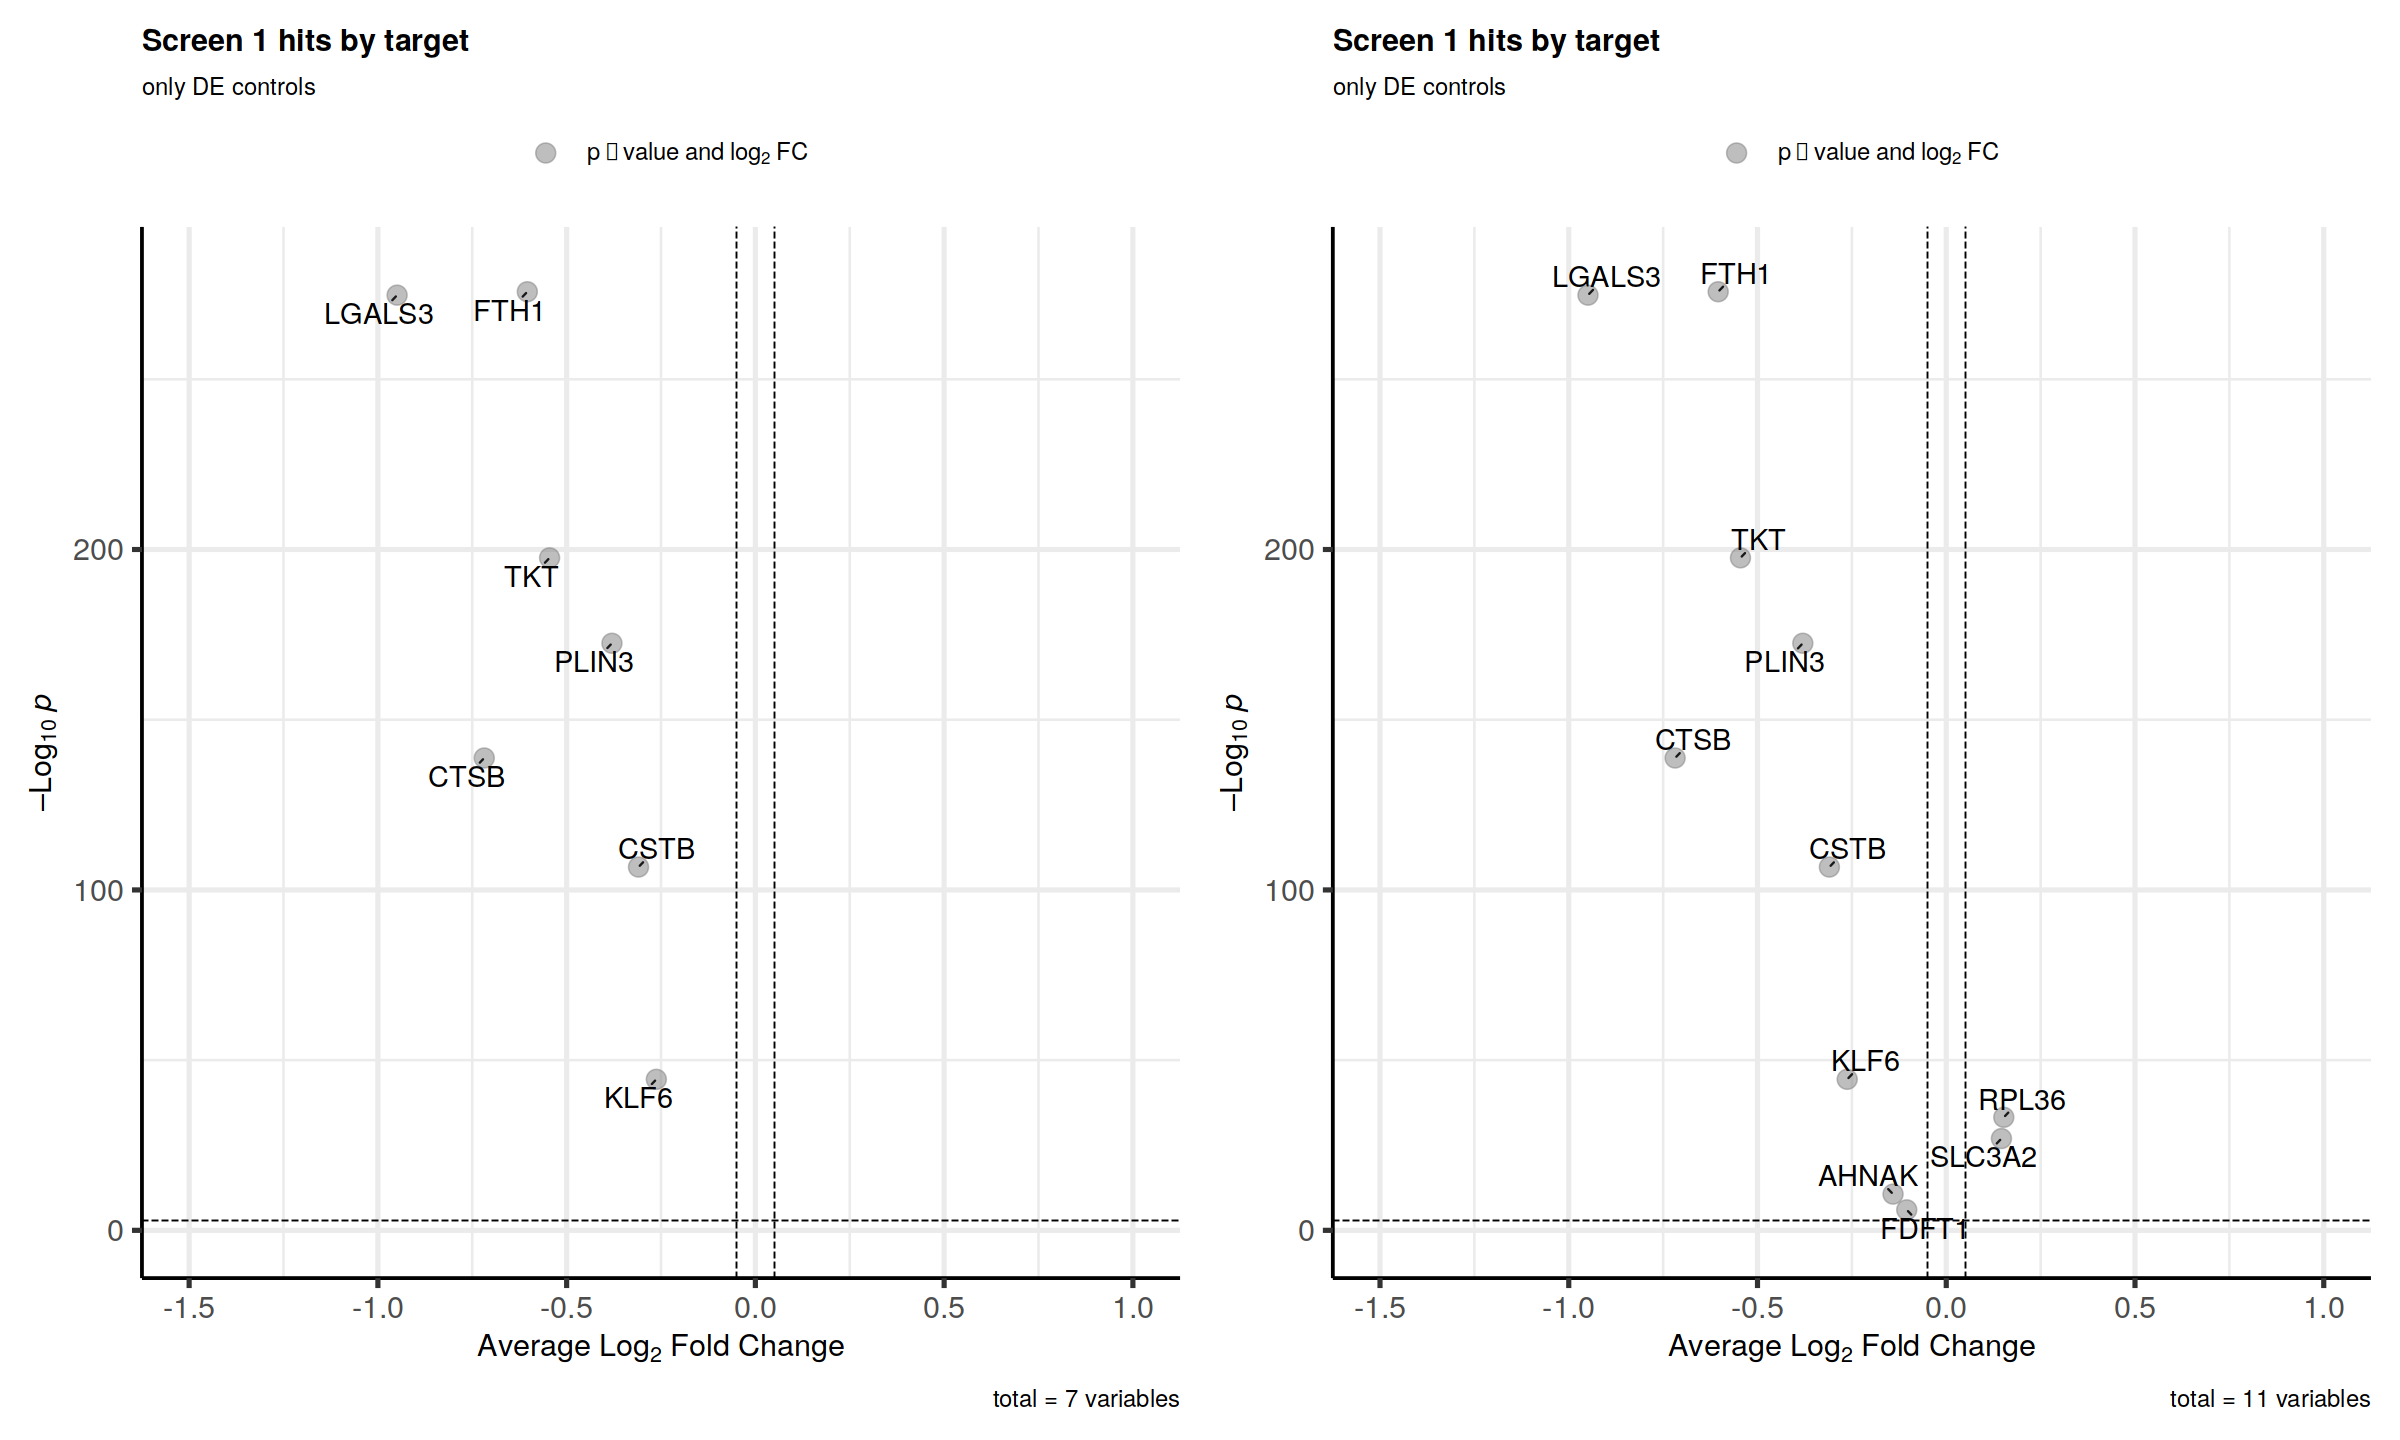

In [ ]:
de_filter = (df_neighbor_de$subclass == 'de_control') & (df_neighbor_de$target == df_neighbor_de$de_gene)
df_neighbor_de_subset = df_neighbor_de[de_filter ,]

options(repr.plot.width = 20, repr.plot.height = 12)
p1 = EnhancedVolcano(df_neighbor_de_subset, 
                lab = df_neighbor_de_subset$de_gene,
                x ="avg_log2FC",
                y ="p_val_adj_mine",
                title = 'Screen 1 hits by target',
                subtitle = 'only DE controls', 
                col = 'gray',
                drawConnectors = TRUE,
                arrowheads = FALSE,
                pCutoff = 10e-4,
                FCcutoff = 0.05,
                pointSize = 5.0,
                labSize = 6.0
                ) +
                xlim(-1.5, 1) +
                xlab(expression(paste("Average ", Log[2], " Fold Change"))) +
                ylab(expression(paste("\u2013", Log[10], " ", italic(p))))


de_filter = (df_neighbor_de$subclass == 'de_control')
df_neighbor_de_subset = df_neighbor_de[de_filter ,]
p2 = EnhancedVolcano(df_neighbor_de_subset, 
                lab = df_neighbor_de_subset$de_gene,
                x ="avg_log2FC",
                y ="p_val_adj_mine",
                title = 'Screen 1 hits by target',
                subtitle = 'only DE controls', 
                col = 'gray',
                drawConnectors = TRUE,
                arrowheads = FALSE,
                pCutoff = 10e-4,
                FCcutoff = 0.05,
                pointSize = 5.0,
                labSize = 6.0
                ) +
                xlim(-1.5, 1) +
                xlab(expression(paste("Average ", Log[2], " Fold Change"))) +
                ylab(expression(paste("\u2013", Log[10], " ", italic(p))))

p1 + p2

### Plot just the CKD DE

Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


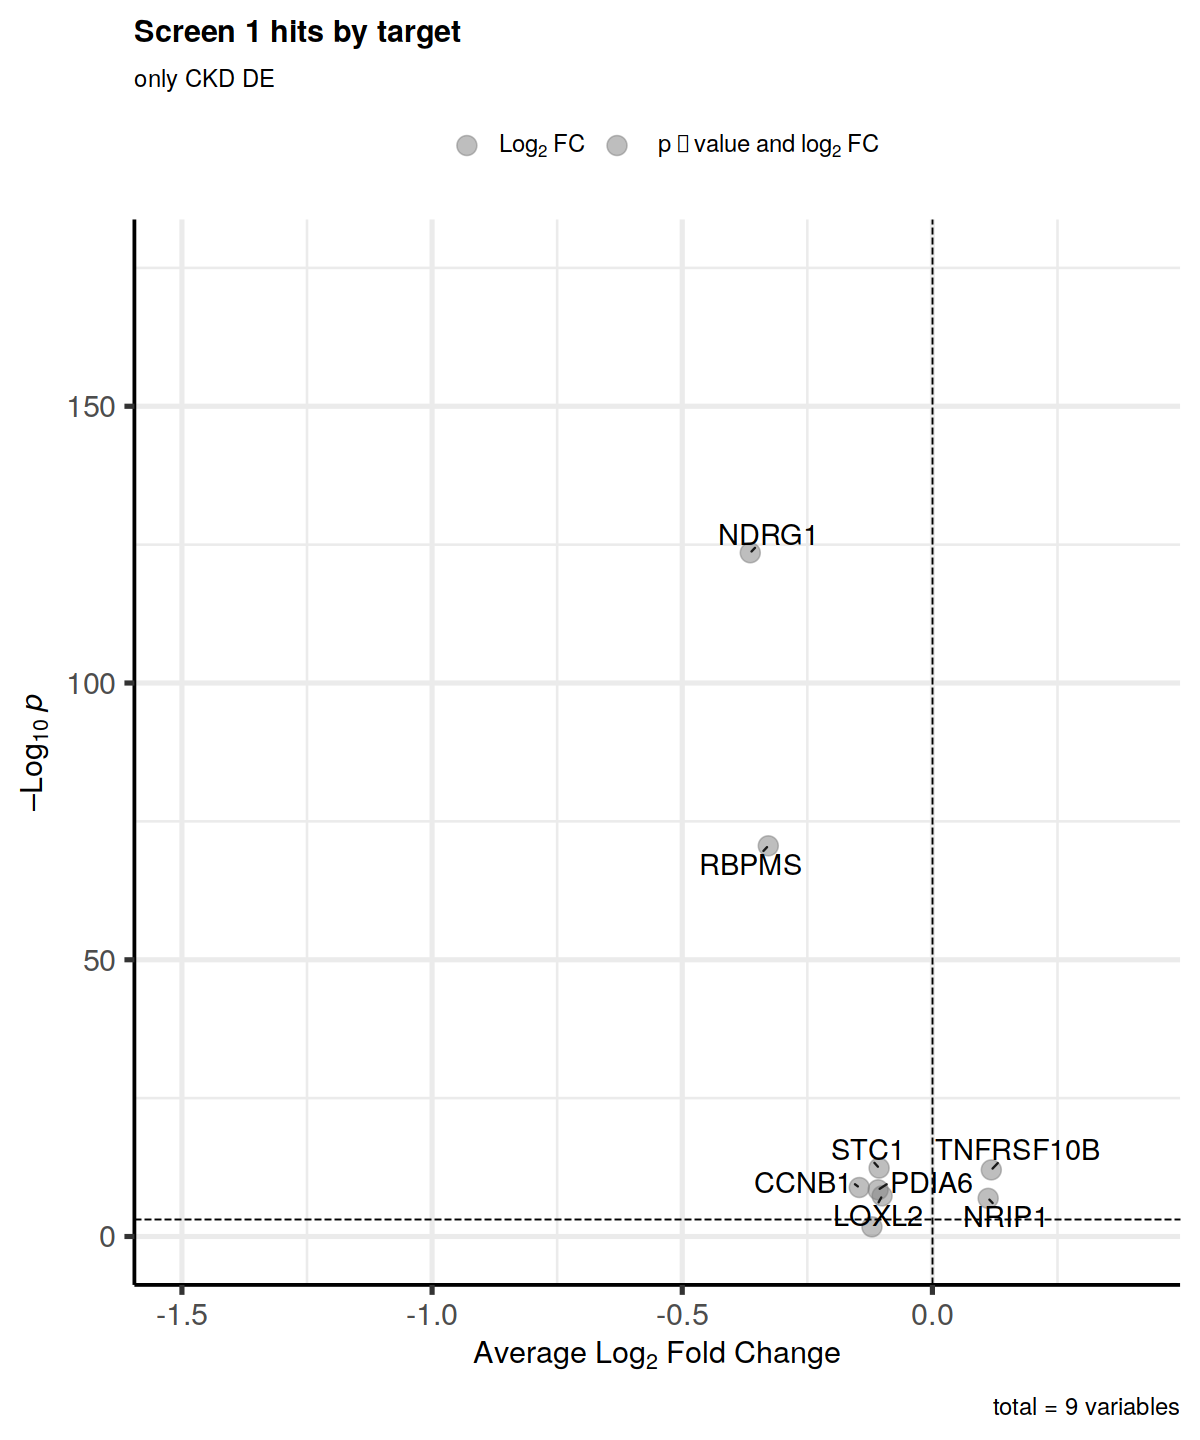

In [ ]:
de_filter = (df_neighbor_de$label == 'CKD DE') 
df_neighbor_de_subset = df_neighbor_de[de_filter ,]

options(repr.plot.width = 10, repr.plot.height = 12)
p1 = EnhancedVolcano(df_neighbor_de_subset, 
                lab = df_neighbor_de_subset$de_gene,
                x ="avg_log2FC",
                y ="p_val_adj_mine",
                title = 'Screen 1 hits by target',
                subtitle = 'only CKD DE', 
                col = 'gray',
                drawConnectors = TRUE,
                arrowheads = FALSE,
                pCutoff = 10e-4,
                FCcutoff = 0.0,
                pointSize = 5.0,
                labSize = 6.0
                ) +
                xlim(-1.5, .4) +
                ylim(0, 175) +
                xlab(expression(paste("Average ", Log[2], " Fold Change"))) +
                ylab(expression(paste("\u2013", Log[10], " ", italic(p))))

p1 

# Inpect DE results

Print top high-confidence hits

In [ ]:
df_neighbor_de %>% filter(avg_log2FC > 0) %>% arrange(p_val_adj_mine) %>% head(10)

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,de_gene,target,subclass,label,p_val_adj_mine
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>
1,8.6e-37,0.15,1.00,1.00,3.2e-32,RPL36,PLIN3,de_control,Control DE,6.3e-34
2,1.5e-30,0.15,0.85,0.78,5.6e-26,SLC3A2,FTH1,de_control,Control DE,1.1e-27
3,1.3e-15,0.12,0.83,0.77,4.6e-11,TNFRSF10B,DE7,ckd_de,CKD DE,9.2e-13
4,1.8e-10,0.11,0.94,0.91,6.4e-06,NRIP1,DE1,ckd_de,CKD DE,1.3e-07


In [ ]:
df_neighbor_de %>% filter((subclass == 'tss')) %>% arrange(p_val_adj_mine) %>% head(30)

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,de_gene,target,subclass,label,p_val_adj_mine
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>
1,6.4e-276,-0.76,0.317,0.80,2.3e-271,NT5E,NT5E,tss,Control TSS,4.6e-273
2,7.5e-200,-0.38,0.152,0.59,2.7e-195,C15orf40,C15orf40,tss,Control TSS,5.4e-197
3,1.9e-151,-0.64,0.455,0.78,6.8e-147,ANPEP,ANPEP,tss,Control TSS,1.4e-148
4,1.9e-103,-0.22,0.082,0.37,7.1e-99,CD55,CD55,tss,Control TSS,1.4e-100
5,4.3e-58,-0.27,0.461,0.68,1.6e-53,FUBP1,FUBP1,tss,Control TSS,3.1e-55
6,8.4e-36,-0.11,0.075,0.24,3.1e-31,MAFF,MAFF,tss,Control TSS,6.1e-33
7,9.2e-14,-0.14,0.775,0.83,3.4e-09,IDH2,ANPEP,tss,Control TSS,6.7e-11
8,7.3e-08,-0.19,0.973,0.98,2.7e-03,LGALS1,MAFF,tss,Control TSS,5.3e-05


In [ ]:
df_neighbor_de %>% filter((label == 'CKD DE') & (p_val_adj_mine < 0.05)) %>% arrange(p_val_adj_mine) 

p_val,avg_log2FC,pct.1,pct.2,p_val_adj,de_gene,target,subclass,label,p_val_adj_mine
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>
4.1e-127,-0.36,0.51,0.68,1.5e-122,NDRG1,DE6,ckd_de,CKD DE,3.0e-124
3.6e-74,-0.33,0.95,0.97,1.3e-69,RBPMS,DE15,ckd_de,CKD DE,2.6e-71
6.0e-16,-0.11,0.32,0.40,2.2e-11,STC1,DE7,ckd_de,CKD DE,4.4e-13
1.3e-15,0.12,0.83,0.77,4.6e-11,TNFRSF10B,DE7,ckd_de,CKD DE,9.2e-13
2.0e-12,-0.15,0.23,0.26,7.2e-08,CCNB1,DE4,ckd_de,CKD DE,1.4e-09
5.1e-12,-0.11,0.97,0.97,1.9e-07,PDIA6,DE10,ckd_de,CKD DE,3.7e-09
6.3e-11,-0.10,0.51,0.55,2.3e-06,LOXL2,DE7,ckd_de,CKD DE,4.6e-08
1.8e-10,0.11,0.94,0.91,6.4e-06,NRIP1,DE1,ckd_de,CKD DE,1.3e-07
2.5e-05,-0.12,0.59,0.61,9.1e-01,PKHD1,DE16,ckd_de,CKD DE,1.8e-02


In [ ]:
df_neighbor_de %>% filter((subclass == 'de_control') & (p_val_adj_mine < 1)) %>% arrange(p_val_adj_mine) 

p_val,avg_log2FC,pct.1,pct.2,p_val_adj,de_gene,target,subclass,label,p_val_adj_mine
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>
0.0e+00,-0.60,1.00,1.00,0.0e+00,FTH1,FTH1,de_control,Control DE,0.0e+00
2.7e-278,-0.95,0.80,0.92,9.8e-274,LGALS3,LGALS3,de_control,Control DE,1.9e-275
3.9e-201,-0.55,0.94,0.98,1.4e-196,TKT,TKT,de_control,Control DE,2.8e-198
4.9e-176,-0.38,0.65,0.81,1.8e-171,PLIN3,PLIN3,de_control,Control DE,3.5e-173
2.4e-142,-0.72,0.94,0.96,8.9e-138,CTSB,CTSB,de_control,Control DE,1.8e-139
2.7e-110,-0.31,0.95,0.98,9.7e-106,CSTB,CSTB,de_control,Control DE,1.9e-107
6.0e-48,-0.26,0.86,0.90,2.2e-43,KLF6,KLF6,de_control,Control DE,4.4e-45
8.6e-37,0.15,1.00,1.00,3.2e-32,RPL36,PLIN3,de_control,Control DE,6.3e-34
1.5e-30,0.15,0.85,0.78,5.6e-26,SLC3A2,FTH1,de_control,Control DE,1.1e-27


## Print top hits w/o log FC filtering

In [ ]:
targets  = unique(df_neighbor_de$target)
col_list = c('target', 'de_gene', 'avg_log2FC', 'p_val_adj_mine', 'label')
df_top_hits = NULL

for(t in targets){
    df_dummy = filter(df_neighbor_de[, col_list], (target == t)) %>% arrange(p_val_adj_mine) %>% head(2)
    #colnames(df_dummy) = NULL
    if(nrow(df_dummy)>0) {
        #print(df_dummy)
        df_top_hits = rbind(df_top_hits, df_dummy)
    }
    else {
        cat(green("Skipping ", t), "\n")
    }
    #cat(yellow("-----------------------------------------------------------\n\n\n"))
}

In [ ]:
#df_top_hits %>% filter(label == "Control TSS")
#df_top_hits %>% filter(label == "Control DE")
df_top_hits %>% filter(label == "CKD DE")

target,de_gene,avg_log2FC,p_val_adj_mine,label
<chr>,<chr>,<dbl>,<dbl>,<chr>
DE16,PKHD1,-0.12,1.8e-02,CKD DE
DE15,RBPMS,-0.33,2.6e-71,CKD DE
DE10,PDIA6,-0.11,3.7e-09,CKD DE
DE7,STC1,-0.11,4.4e-13,CKD DE
DE7,TNFRSF10B,0.12,9.2e-13,CKD DE
DE6,NDRG1,-0.36,3.0e-124,CKD DE
DE4,CCNB1,-0.15,1.4e-09,CKD DE
DE1,NRIP1,0.11,1.3e-07,CKD DE


## Print top hits w/ avg LogFC >0

In [ ]:
targets  = unique(df_neighbor_de$target)
col_list = c('target', 'de_gene', 'avg_log2FC', 'p_val_adj_mine', 'label')
df_top_hits = NULL

for(t in targets){
    df_dummy = filter(df_neighbor_de[, col_list], (target == t) & (avg_log2FC > 0)) %>% arrange(p_val_adj_mine) %>% head(2)
    #colnames(df_dummy) = NULL   
    if(nrow(df_dummy)>0) {
        #print(df_dummy)
        df_top_hits = rbind(df_top_hits, df_dummy)
    }
    else {
        cat(green("Skipping ", t), "\n")
    }
    #cat(yellow("-----------------------------------------------------------\n\n\n"))
}

Skipping  DE16 
Skipping  DE15 
Skipping  DE10 
Skipping  DE6 
Skipping  DE4 
Skipping  KLF6 
Skipping  CTSB 
Skipping  CSTB 
Skipping  LGALS3 
Skipping  TKT 
Skipping  MAFF 
Skipping  C15orf40 
Skipping  FUBP1 
Skipping  NT5E 
Skipping  CD55 
Skipping  ANPEP 


In [ ]:
df_top_hits %>% filter(label == "CKD DE")

target,de_gene,avg_log2FC,p_val_adj_mine,label
<chr>,<chr>,<dbl>,<dbl>,<chr>
DE7,TNFRSF10B,0.12,9.2e-13,CKD DE
DE1,NRIP1,0.11,1.3e-07,CKD DE


# Visualize Knockdowns

## TSS controls

[1] "ANPEP"
CD13-1a   818 
CD13-1b   1091 
Guide+ = 1091 ; Guide- = 26051 
[1] "CD55"
CD55-1a   753 
CD55-1b   1024 
Guide+ = 1024 ; Guide- = 26118 
[1] "NT5E"
CD73-1a   704 
CD73-1b   954 
Guide+ = 954 ; Guide- = 26188 
[1] "FUBP1"
FUBP1-1a   675 
FUBP1-1b   874 
Guide+ = 874 ; Guide- = 26268 
[1] "C15orf40"
C15orf40-1a   780 
C15orf40-1b   1018 
Guide+ = 1018 ; Guide- = 26124 
[1] "MAFF"
MAFF-1a   622 
MAFF-1b   812 
Guide+ = 812 ; Guide- = 26330 


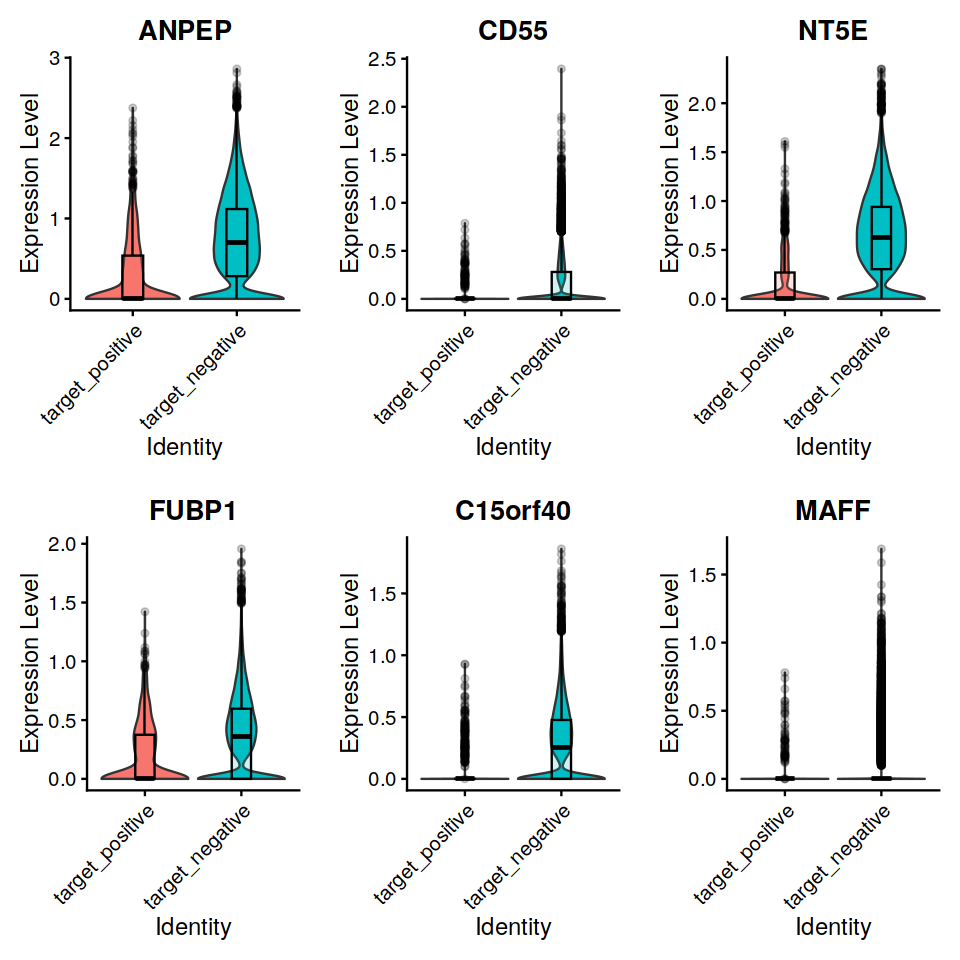

In [ ]:
targets = unique(filter(df_guide, subclass=='tss')$alias)
plots = vlnplot_for_targets(seurat_rna, df_guide, perturbed_cells_by_guide, targets)
options(repr.plot.width=8, repr.plot.height=8)
ggarrange(plotlist=plots, ncol=3, nrow = 2)

## DE controls

[1] "FTH1"
FTH1-1a   595 
FTH1-2a   3026 
FTH1-1b   3189 
FTH1-2b   3189 
Guide+ = 3189 ; Guide- = 23953 
[1] "PLIN3"
PLIN3-1a   827 
PLIN3-2a   1500 
PLIN3-1b   1722 
PLIN3-2b   1948 
Guide+ = 1948 ; Guide- = 25194 
[1] "TKT"
TKT-1a   632 
TKT-2a   1414 
TKT-1b   1606 
TKT-2b   1868 
Guide+ = 1868 ; Guide- = 25274 
[1] "LGALS3"
LGALS3-1a   862 
LGALS3-2a   1569 
LGALS3-1b   1794 
LGALS3-2b   2016 
Guide+ = 2016 ; Guide- = 25126 
[1] "CSTB"
CSTB-1a   882 
CSTB-2a   1699 
CSTB-1b   1961 
CSTB-2b   2208 
Guide+ = 2208 ; Guide- = 24934 
[1] "CTSB"
CTSB-1a   919 
CTSB-2a   1673 
CTSB-1b   1904 
CTSB-2b   2079 
Guide+ = 2079 ; Guide- = 25063 
[1] "KLF6"
KLF6-1a   810 
KLF6-2a   1626 
KLF6-1b   1876 
KLF6-2b   2080 
Guide+ = 2080 ; Guide- = 25062 


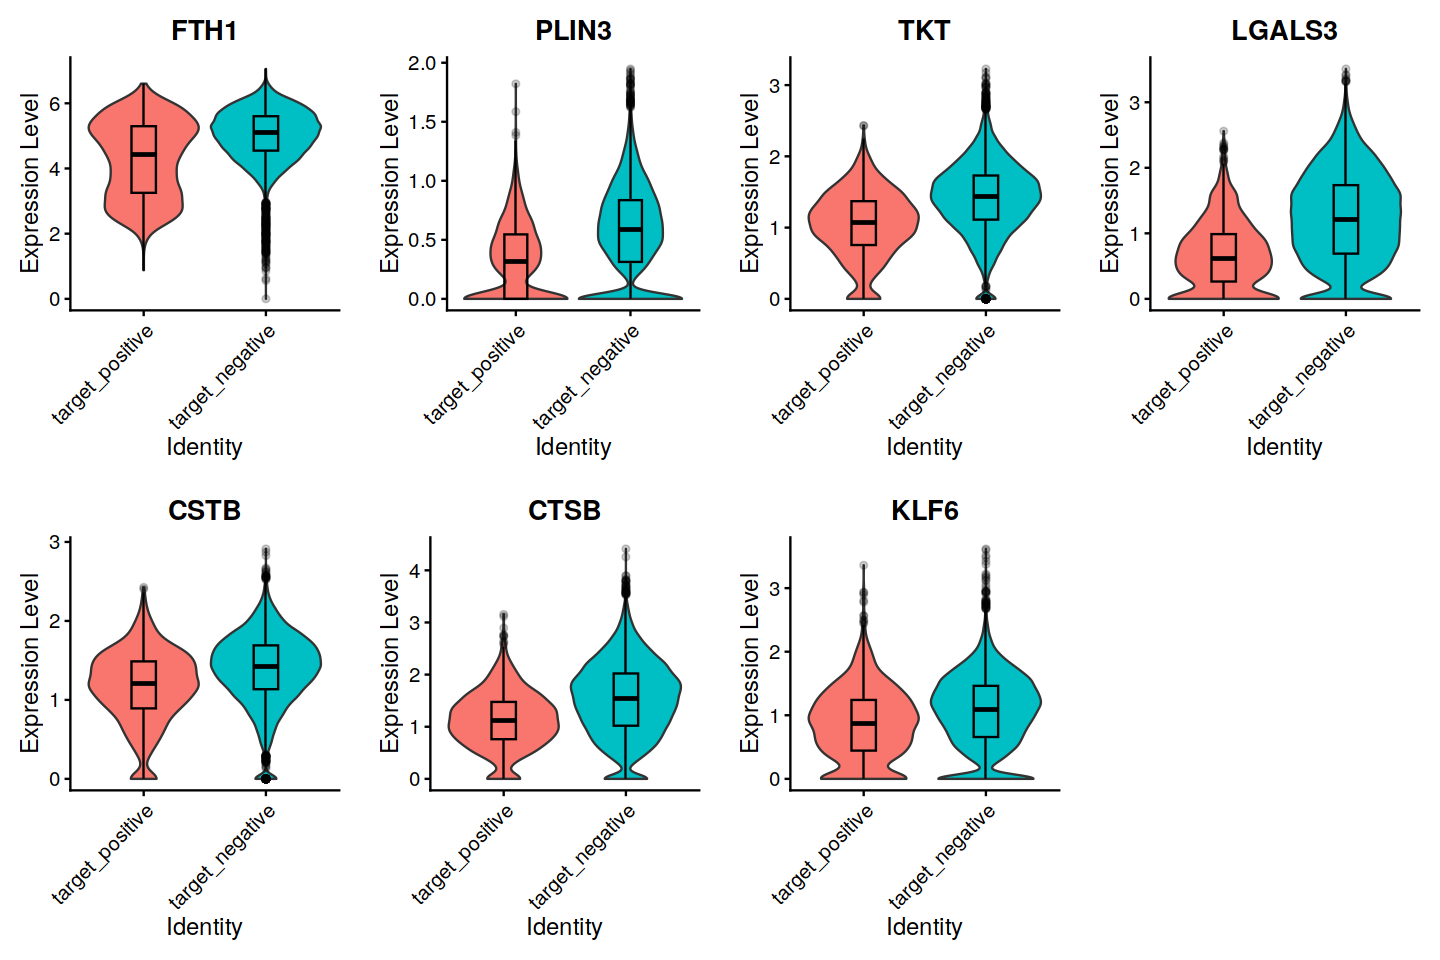

In [ ]:
targets = unique(filter(df_guide, subclass=='de_control')$alias)
plots = vlnplot_for_targets(seurat_rna, df_guide, perturbed_cells_by_guide, targets)
options(repr.plot.width=12, repr.plot.height=8)
ggarrange(plotlist=plots, ncol=4, nrow = 2)

## CKD DE 

[1] "DE22"
Guide+ = 0 ; Guide- = 27142 


[1] "DE15"
Guide+ = 2198 ; Guide- = 24944 


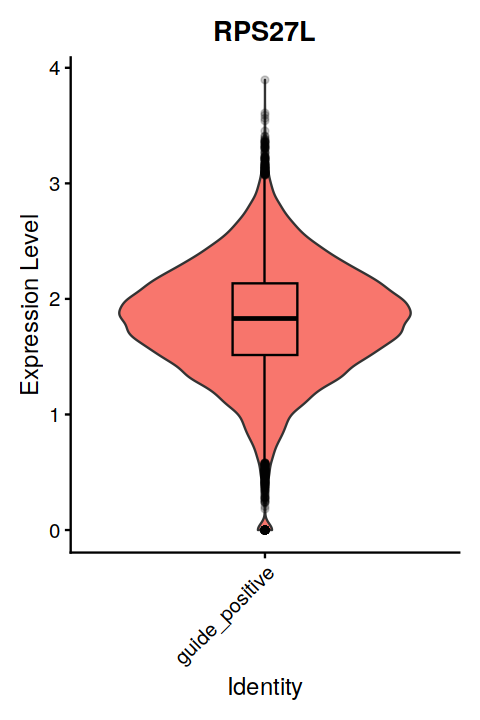

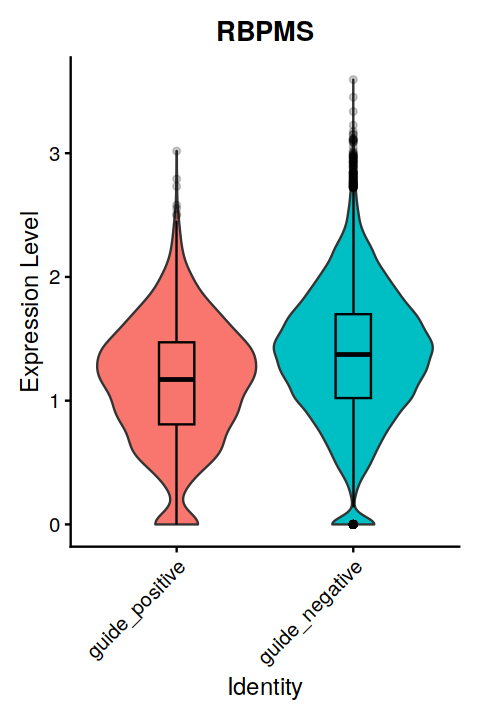

In [ ]:
target = "DE22"
regulated_gene = "RPS27L"
print(target)
guides = get_guides_by_subclass(df_guide, 'alias', target)
seurat_rna <- mark_guide_pos_neg(
    seurat_rna, 
    perturbed_cells_by_guide, 
    guides, 
    print_counts = T
)

plt1 <- VlnPlot(
    object = seurat_rna,
    features = regulated_gene, 
    idents = NULL, 
    pt.size = 0, 
    sort = F, 
    ncol = 1,    
) +
geom_boxplot(width=0.2, color="black", alpha=0.2) + 
theme(legend.position = 'none', plot.subtitle = element_text(hjust = 0.5))     



target = "DE15"
regulated_gene = "RBPMS"
print(target)
guides = get_guides_by_subclass(df_guide, 'alias', target)
seurat_rna <- mark_guide_pos_neg(
    seurat_rna, 
    perturbed_cells_by_guide, 
    guides, 
    print_counts = T
)

plt2 <- VlnPlot(
    object = seurat_rna,
    features = regulated_gene, 
    idents = NULL, 
    pt.size = 0, 
    sort = F, 
    ncol = 1,    
) +
geom_boxplot(width=0.2, color="black", alpha=0.2) + 
theme(legend.position = 'none', plot.subtitle = element_text(hjust = 0.5))     

options(repr.plot.width=4, repr.plot.height=6)
print(plt1) 
print(plt2)

### Violin plots for all DEs

In [ ]:
vlnplot_for_de_targets <- function(seurat_obj, df_guide, perturbed_cells_by_guide, df_target_vs_regulated) {
    plt_list = list()
    for(i in 1:nrow(df_target_vs_regulated)) {
        target = df_target_vs_regulated[i, 'target']
        regulated_gene = df_target_vs_regulated[i, 'de_gene']
        my_p_val = df_target_vs_regulated[i, 'p_val_adj_mine']
        my_p_val = formatC(my_p_val, format = "e", digits = 1)
        title = paste0(target, ": ", regulated_gene)
        subtitle = paste("Adjusted p =", my_p_val)
        
        guides = get_guides_by_subclass(df_guide, 'alias', target)
        seurat_dummy <- mark_target_pos_neg(
            seurat_rna,
            perturbed_cells_by_guide, 
            guides, 
            print_counts = F
        )

        options(repr.plot.width=5, repr.plot.height=4)
        plt <- VlnPlot(
            object = seurat_dummy,
            features =  regulated_gene, 
            idents = NULL, 
            pt.size = 0., 
            sort = F, 
            ncol = 1,    
        ) + 
            geom_boxplot(width=.2, color="black", alpha=0.2) + theme(legend.position = 'none') +
            labs(title = title, subtitle = subtitle)
        plt_list[[i]] = plt
    }
    plt_list
}


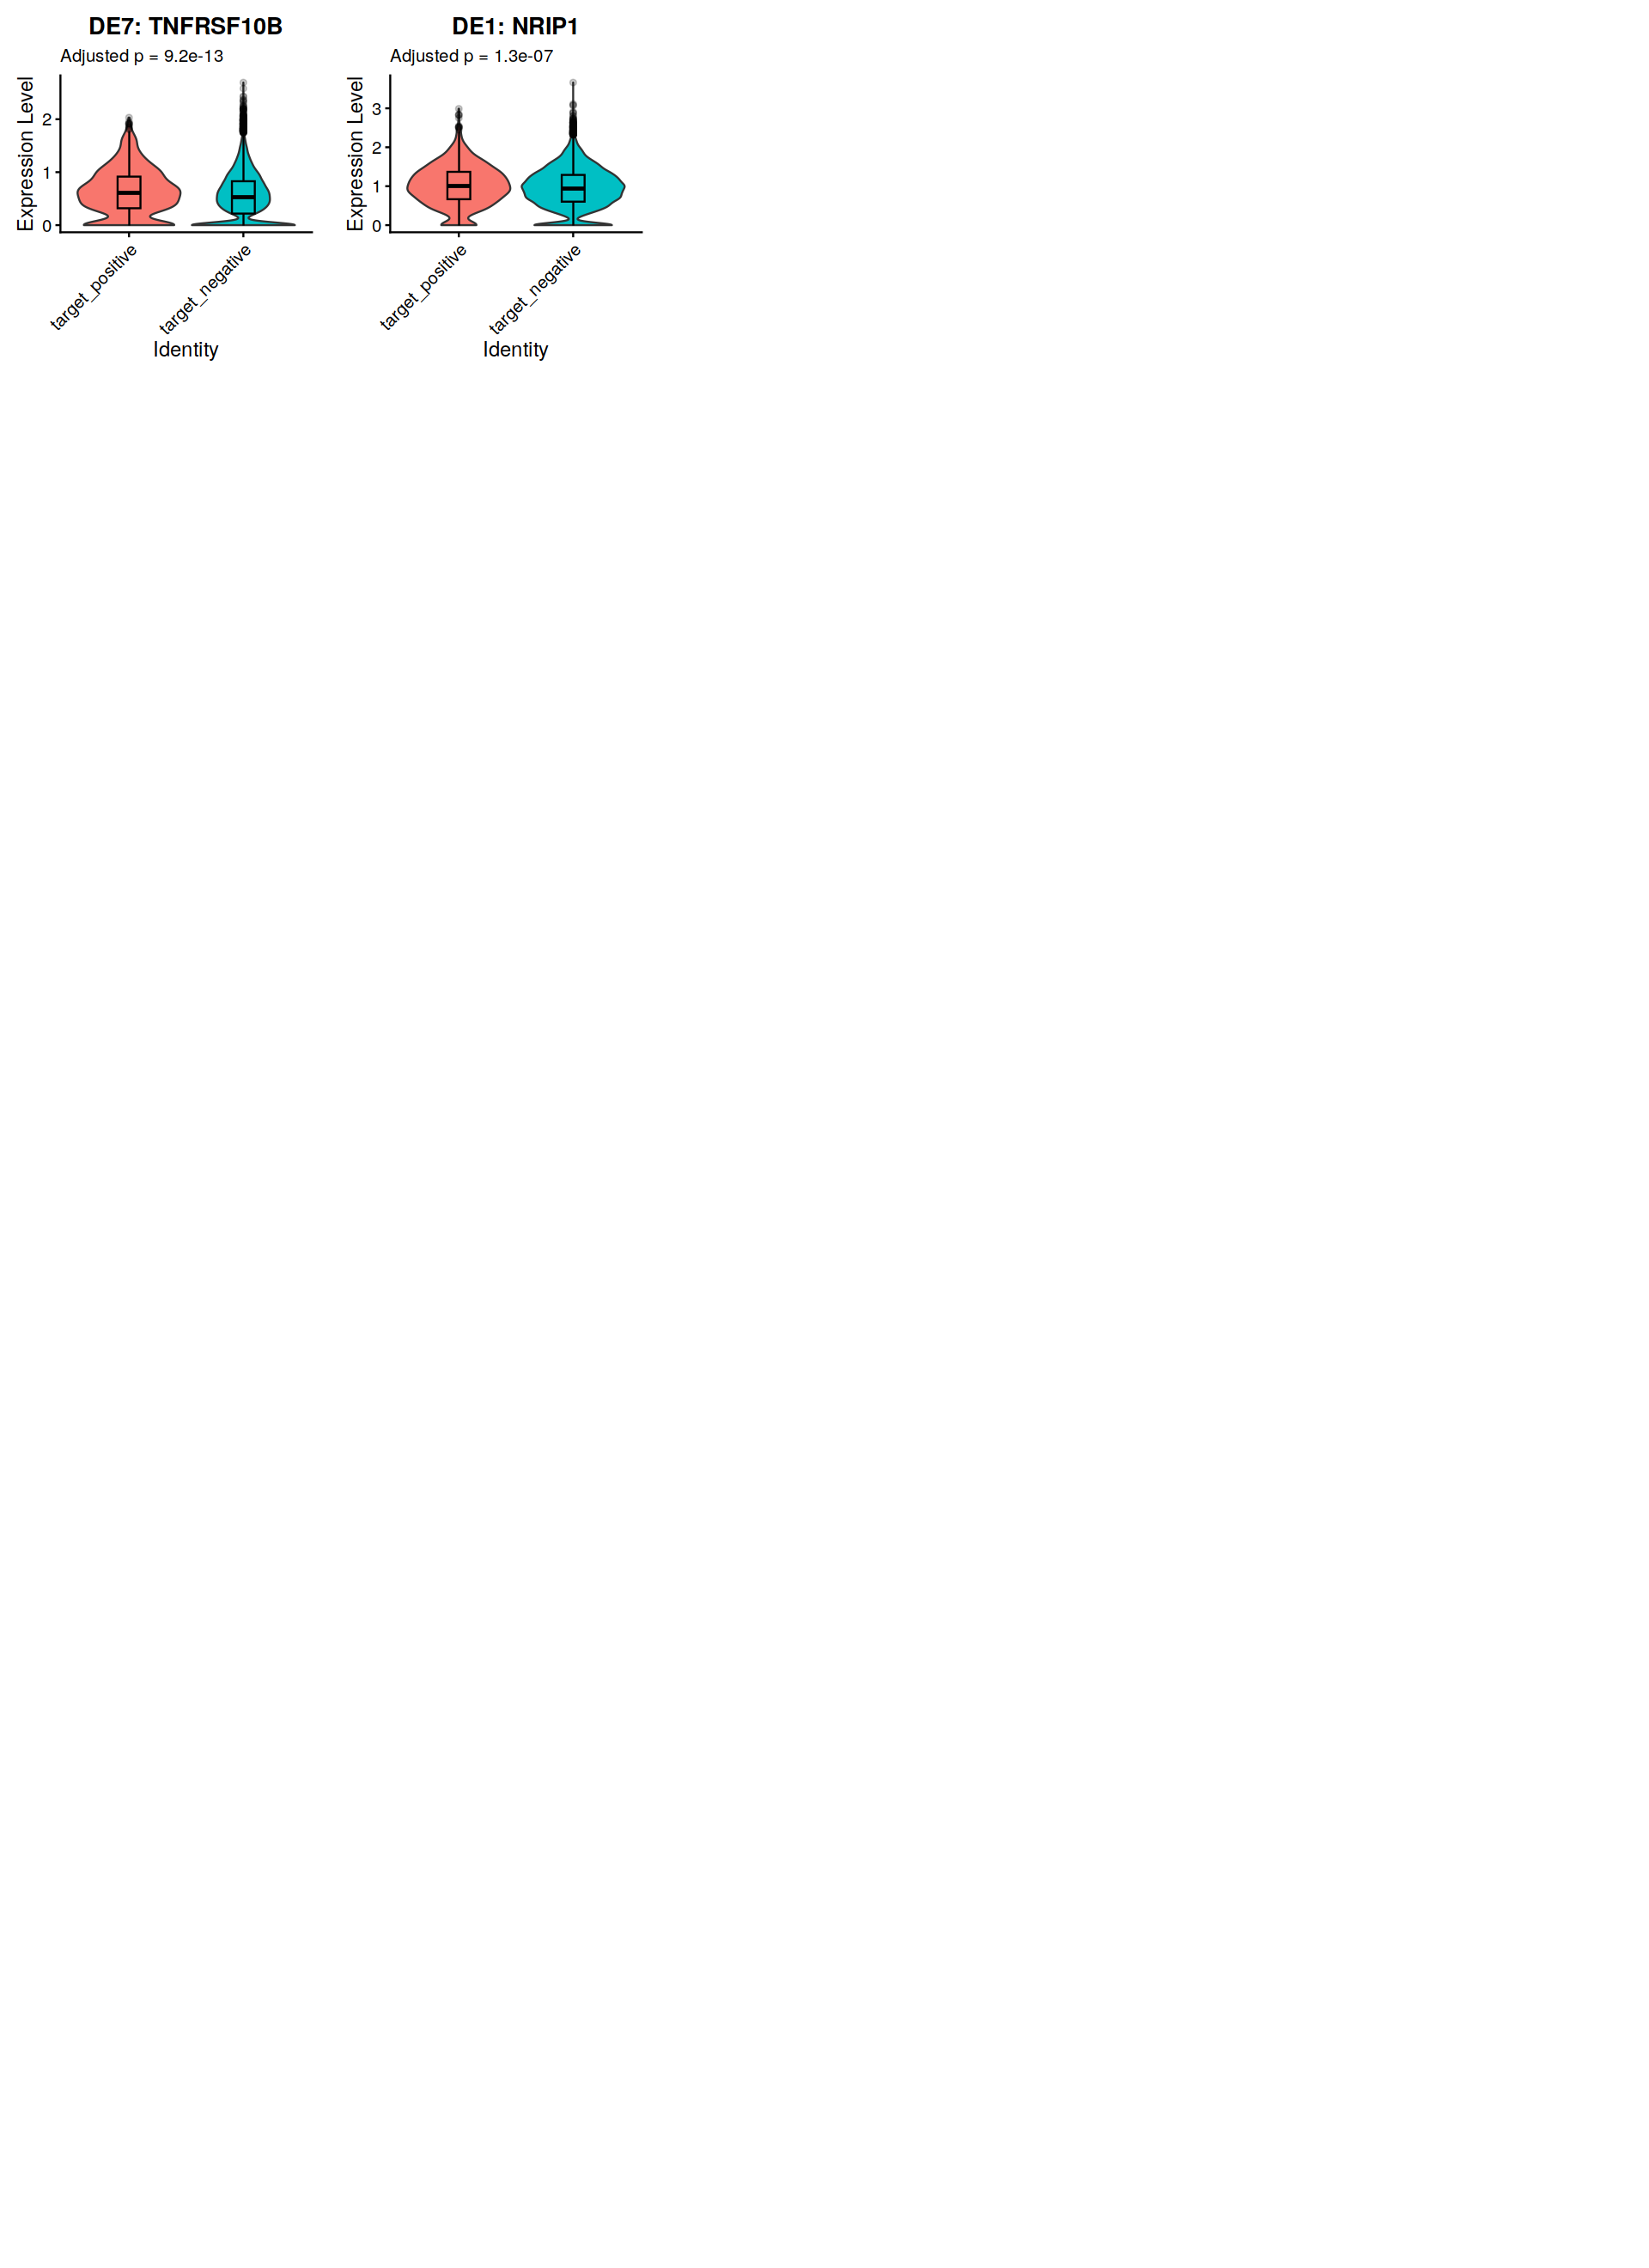

In [ ]:
df_top_distal_hits = df_top_hits %>% filter(label == "CKD DE")
df_target_vs_regulated = df_top_hits %>% filter(label == "CKD DE")
plots = vlnplot_for_de_targets(seurat_rna, df_guide, perturbed_cells_by_guide, df_top_distal_hits)

options(repr.plot.width=16, repr.plot.height=22)
ggarrange(plotlist=plots, ncol=5, nrow = 6)


# Debug

In [ ]:
target = "DE6"
regulated_gene = "NDRG1"
print(target)
guides = get_guides_by_subclass(df_guide, 'alias', target)
seurat_rna <- mark_guide_pos_neg(
    seurat_rna, 
    perturbed_cells_by_guide, 
    guides, 
    print_counts = T
)

[1] "DE6"
Guide+ = 2655 ; Guide- = 24487 


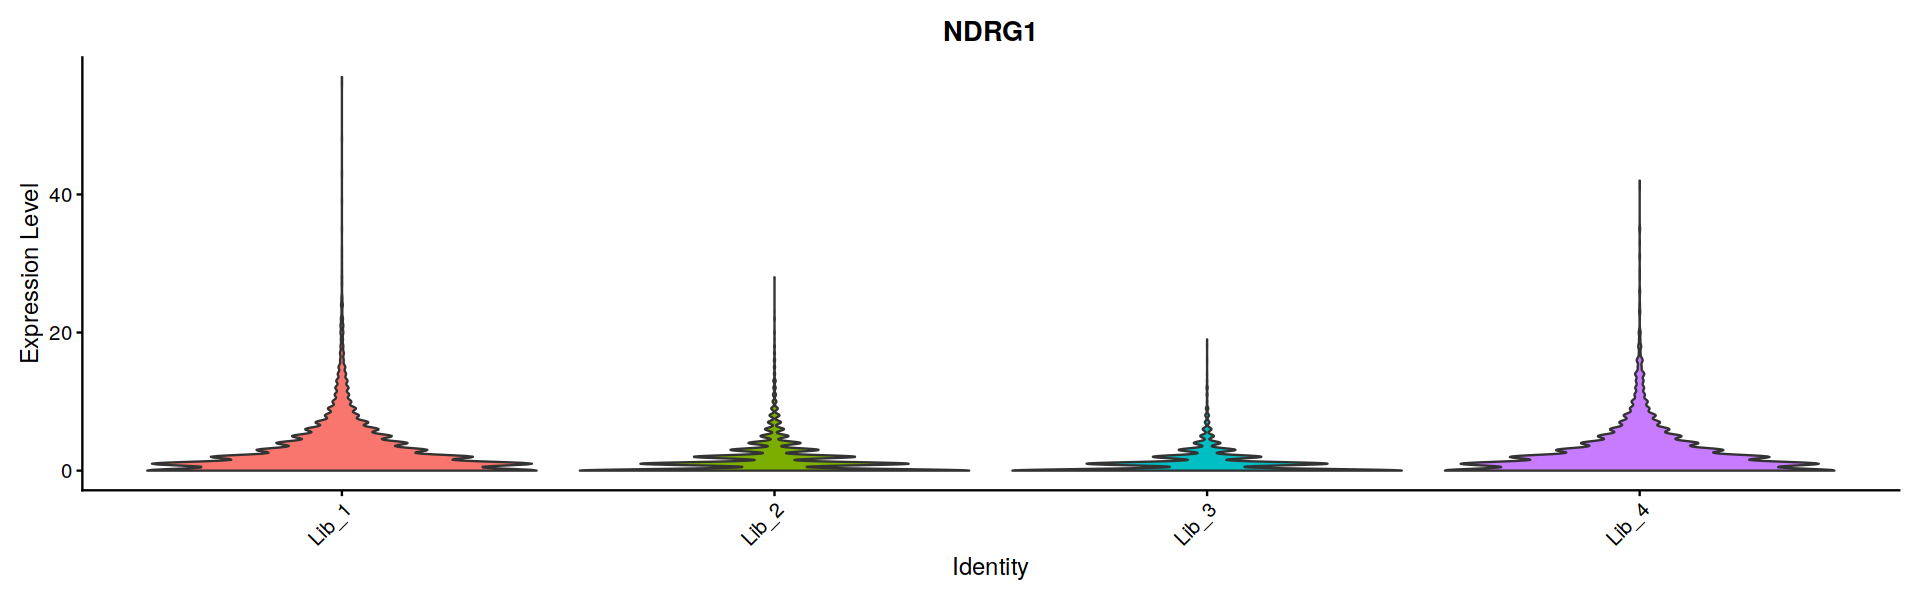

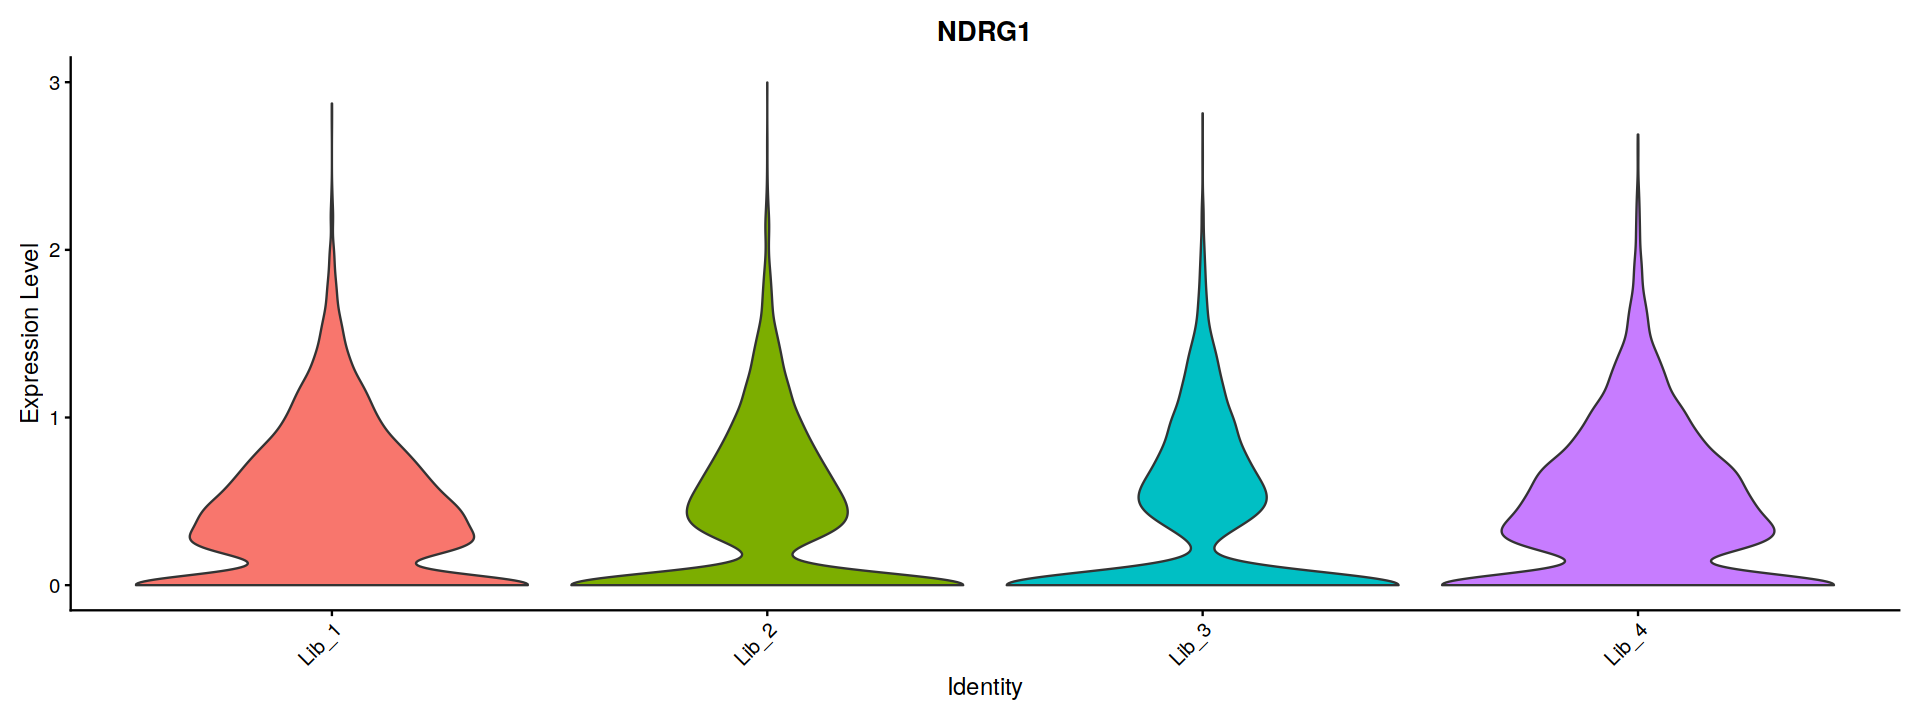

In [ ]:
options(repr.plot.width=16, repr.plot.height=5)
VlnPlot(
    object = seurat_rna,
    idents = "guide_negative",
    slot = 'counts',
    features = c("NDRG1"),
    pt.size = 0.,
    group.by = 'library',
  ) +  theme(legend.position="none")

options(repr.plot.width=16, repr.plot.height=6)
VlnPlot(
    object = seurat_rna,
    idents = "guide_negative",
    slot = 'data',
    features = c("NDRG1"),
    pt.size = 0,
    group.by = 'library'
  ) +  theme(legend.position="none")


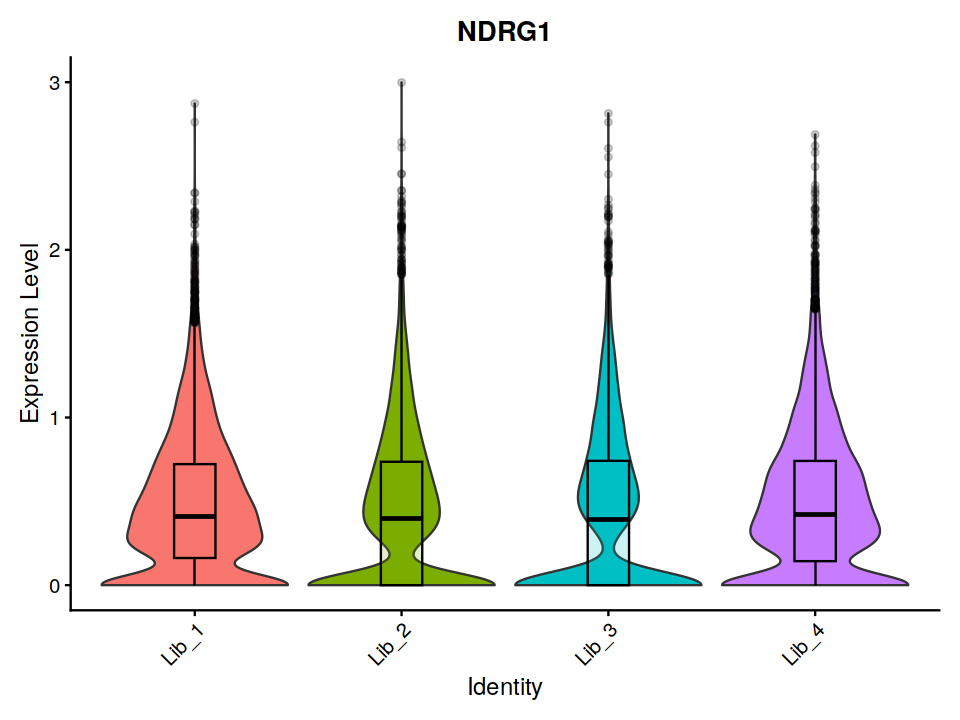

In [ ]:
plt1 <- VlnPlot(
    object = seurat_rna,
    features = regulated_gene, 
    ident = 'guide_negative',
    slot = 'data', 
    pt.size = 0, 
    sort = F, 
    ncol = 1,
    group.by = 'library',
) +
geom_boxplot(width=0.2, color="black", alpha=0.2) + 
theme(legend.position = 'none', plot.subtitle = element_text(hjust = 0.5))     

options(repr.plot.width=8, repr.plot.height=6)
plt1

[1] "DE15"
Guide+ = 2198 ; Guide- = 24944 


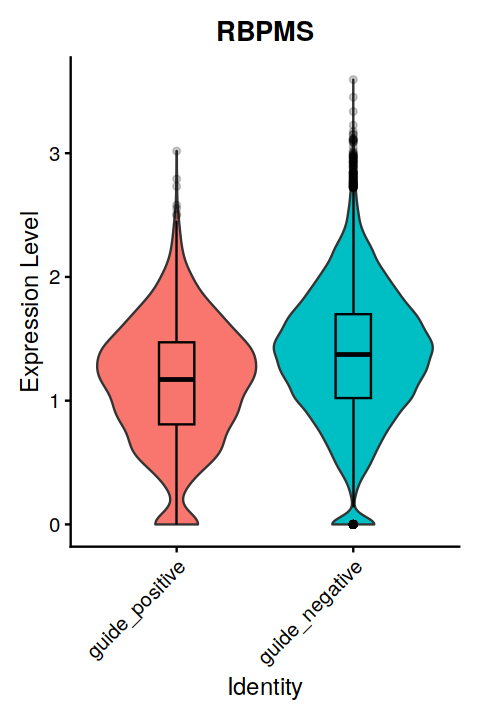

In [ ]:
target = "DE15"
regulated_gene = "RBPMS"
print(target)
guides = get_guides_by_subclass(df_guide, 'alias', target)
seurat_rna <- mark_guide_pos_neg(
    seurat_rna, 
    perturbed_cells_by_guide, 
    guides, 
    print_counts = T
)

plt2 <- VlnPlot(
    object = seurat_rna,
    features = regulated_gene, 
    idents = NULL, 
    pt.size = 0, 
    sort = F, 
    ncol = 1,    
) +
geom_boxplot(width=0.2, color="black", alpha=0.2) + 
theme(legend.position = 'none', plot.subtitle = element_text(hjust = 0.5))     

options(repr.plot.width=4, repr.plot.height=6)
print(plt2)